In [1]:
in_colab = False
try:
    import google.colab
    in_colab = True
except:
    in_colab = False
in_colab

True

In [2]:
import matplotlib
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)
font = {'family' : '',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
if in_colab:
  !pip install neurokit2
  !pip install torchinfo
  !pip install pytorch_lightning
  !pip install wfdb
  !pip install pycwt
  !pip install torch==2.0.1 torchvision==0.15.2 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 78.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

In [4]:
import torch
from torch import optim, nn
from IPython.display import clear_output
from torchinfo import summary
import os
import pywt as pw
from math import ceil
import cv2
from matplotlib import cm
from matplotlib import rcParams
import pytorch_lightning as pl
import imageio
import gc
import collections
from pytorch_lightning.loggers import Logger
from pytorch_lightning.loggers.logger import rank_zero_experiment
from pytorch_lightning.utilities import rank_zero_only
import scipy
import pandas as pd
import wfdb
import matplotlib.pyplot as plt
import ast
import os
import warnings
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2 as cv

gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

warnings.simplefilter(action='ignore', category=FutureWarning)
rcParams['font.weight'] = 'bold'
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [5]:
if in_colab:
  from google.colab import drive
  drive.mount("/content/drive/", force_remount = True)
  %cd "drive/MyDrive/Colab Notebooks/ECG_SuperResolution"

Mounted at /content/drive/
/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution


In [6]:
if in_colab:
    !ls
else:
    !dir

 activationmap_superresolution_labelCD_ch0-1_noised.png
 activationmap_superresolution_labelCD_nonoise.png
 activationmap_superresolution_labelCD.png
 activationmap_superresolution_labelHYP_ch0-1_noised.png
 activationmap_superresolution_labelHYP_nonoise.png
 activationmap_superresolution_labelHYP.png
 activationmap_superresolution_labelMI_ch0-1_noised.png
 activationmap_superresolution_labelMI_nonoise.png
 activationmap_superresolution_labelMI.png
 activationmap_superresolution_labelNORM_ch0-1_noised.png
'activationmap_superresolution_labelNORM_idx10_noiseEDA artifact.png'
'activationmap_superresolution_labelNORM_idx10_noiseEMG artifact.png'
 activationmap_superresolution_labelNORM_idx10_noiseNO.png
'activationmap_superresolution_labelNORM_idx10_noiseRespiration Noise.png'
 activationmap_superresolution_labelNORM_nonoise.png
 activationmap_superresolution_labelNORM.png
 activationmap_superresolution_labelSTTC_ch0-1_noised.png
 activationmap_superresolution_labelSTTC_nonoise.png
 activ

In [7]:
from functions import *

In [8]:
channels = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
channels_map = {idx: channel for idx, channel in enumerate(channels)}

In [9]:
!python --version

Python 3.10.12


In [10]:
torch.__version__

'2.0.1+cu118'

In [11]:
torch.cuda.is_available()

True

In [12]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [13]:
%matplotlib inline

In [14]:
map_superclass_rev = {'CD': 0, 'HYP': 1, 'MI': 2, 'NORM': 3, 'STTC': 4, 'All': 99}


In [15]:
if not in_colab:
  %matplotlib qt
  plt.close("all")

In [16]:
torch.set_float32_matmul_precision("medium")

In [17]:
labels = list(map_superclass_rev.keys())

In [18]:
fs_lr = 50
fs_hr = 500

In [ ]:
labels = map_superclass_rev.keys()
X_train_lr = torch.load("x_train_lr_noisy.pt")
X_test_lr = torch.load("x_test_lr_noisy.pt")
X_train_hr = torch.load("x_train_hr.pt")
X_test_hr = torch.load("x_test_hr.pt")
y_train = torch.load("y_train.pt")
y_test = torch.load("y_test.pt")

In [ ]:
label = "All"
dict_windows_train_lr_n = {}
dict_windows_test_lr_n = {}
dict_windows_train_hr = {}
dict_windows_test_hr = {}

dict_windows_train_lr_n["All"] = X_train_lr
dict_windows_test_lr_n["All"] = X_test_lr
dict_windows_train_hr["All"] = X_train_hr
dict_windows_test_hr["All"] = X_test_hr

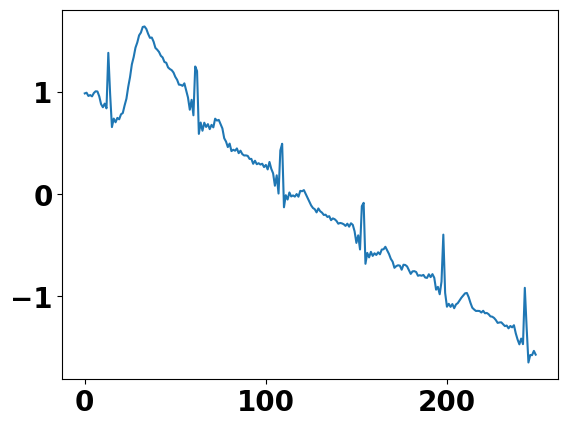

In [ ]:
%matplotlib inline
ch = 0
idx = 59
x = X_train_lr[idx, 0, ch, :].cpu().detach().numpy()
plt.plot(x)
plt.show()

In [26]:
def torch_argwhere_in_list(tensor, list):

    idxs = []
    tensor.flatten()
    for i, elem in enumerate(tensor):
        elem = elem.item()
        for j in list:
            if elem == j:
                idxs.append(i)
    return idxs

In [25]:
channels = ["I", "II", "III", "aVL", "aVR", "aVF", "V1", "V2", "V3", "V4", "V5", "V6" ]
channels_map = {idx: channel for idx, channel in enumerate(channels)}

In [27]:
def run_single_channel(dict_windows_train, dict_windows_test, label, sublabels_train, sublabels_test, channel = 0, ch = None, dict_windows_train_hr = None, dict_windows_test_hr = None, quicktest=False, kernel_sizes = None, out_channels = None, lr_scheduler = False, in_colab = False, kernel_sizes_sr = None, of_sr = None, str_sr = None, loss_type = "lr", sr_type = "none"):

    label_num = map_superclass_rev[label]
    if "hr" in loss_type:
        training_dataloader, _, _, _, _ = get_dataloader(dict_windows_train, sub_labels = sublabels_train, dict_windows_hr = dict_windows_train_hr, channel = ch, loss_type = loss_type, label = label, quicktest=quicktest)
        test_dataloader, to_predict, to_predict_hr, _, _ = get_dataloader(dict_windows_test, sublabels_test = sublabels_test, dict_windows_hr=dict_windows_test_hr, loss_type = loss_type, channel = ch, label = label, quicktest=quicktest)
    else:
        training_dataloader, _, _, _, _ = get_dataloader(dict_windows_train, sub_labels = sublabels_train, channel = ch, label = label, quicktest=quicktest, loss_type = loss_type)
        test_dataloader, to_predict, _, _, _= get_dataloader(dict_windows_test, sub_labels = sublabels_test, channel = ch, label = label, quicktest=quicktest, loss_type = loss_type)
    fig = get_cv2_img(to_predict, ch)
    fig.show()

    if not in_colab:
      %matplotlib qt
    else:
      %matplotlib inline

    plt.close("all")
    plt.rcParams['axes.facecolor']='white'

    import gc
    gc.collect()
    torch.cuda.empty_cache()

    label_num = map_superclass_rev[label]

    #problems with channel: 5 (from 0)
    #kernel_sizes = [[8, 8], [4, 4], [2, 2], [2, 2]]

    strides = [[1, 1] for i in range(len(kernel_sizes))]# STRIDE 1 CONFERMATO

    width = to_predict.shape[-1]
    batch_size = 1
    lr = 0.0001#0.0001
    epochs = 5
    do = 0.1#0.05#need to prevent overfitting, if noisy reconstruction: decrese do
    activation_name = "tanh"
    loss_name = "mse"#"mse"
    epochs_save_preliminar = 10
    model_type = "ae"#vae doesn't reconstructs  well
    nchs = 1
    img = None

    #print([x.shape for x in next(iter(test_dataloader))])
    lr_change  = {epochs: lr}
    model, trainer, model_run = train_1d_model(training_dataloader, width, to_predict, img, label_num, do = do, batch_size=batch_size, model_type = model_type, kernel_sizes = kernel_sizes, outchannels = out_channels, strides = strides, activation_name = activation_name, epochs = epochs, lr = lr, mode = "s", channel = ch, lr_change = lr_change, loss_name = loss_name, epochs_save_preliminar = epochs_save_preliminar, lr_scheduler = lr_scheduler, in_colab = in_colab, loss_type = loss_type, sr_type = sr_type, of_sr =of_sr ,str_sr = str_sr, kernel_sizes_sr = kernel_sizes_sr, to_predict_hr=to_predict_hr)
    return model, trainer

In [36]:
def validate_single_channel(dict_windows_test, dict_windows_test_hr, label, model, channel = None, upsample = False):

    super_resolution_windows = []

    device = "cpu"
    model = model.to(device)
    model.eval()

    testing_data = dict_windows_test[label].to(device)
    testing_data_hr = dict_windows_test_hr[label].to(device)

    for i, window in enumerate(testing_data):
        print("{}/{}".format(i+1, len(testing_data)), end="\r")
        if channel is not None:
            window = window[:, channel, :]
        window = torch.unsqueeze(window, dim = 0).to(device)
        pred = model([window, None, None, None])

        hr_data = testing_data_hr[i]
        if channel is not None:
            hr_data = hr_data[:, channel, :]

        if not upsample:
            sr_data = pred[1]
            sr_data = torch.unsqueeze(sr_data, dim = 0)
        else:
            rec_data = pred[0]
            #rec_data = torch.unsqueeze(rec_data, dim = 0)
            sr_data = resample_signal(rec_data, fs = 500, fin = 50)
        super_resolution_windows.append(sr_data.to(device))
    loss, losses = check_super_resolution_quality(testing_data_hr, super_resolution_windows)
    #super_resolution_windows = [window.to("cpu") for window in super_resolution_windows]
    return loss, losses, super_resolution_windows

In [29]:
import os
cwd = os.getcwd()
sep = os.sep
cwd

'/content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution'

In [ ]:
label = "MI"
nchs = 12
lr_scheduler = False
quicktest = False #train with only a little percentage of the dataset
channels = [i for i in range(5, nchs)]
sr_type = "convt"

In [ ]:
sub_labels_train = {}
sub_labels_train["All"] = y_train
sub_labels_test = {}
sub_labels_test["All"] = y_test

In [ ]:
todo_allchannels = True

In [ ]:
from functions import *

1024
Latent dim:  247808
Encoder ks:  [[3, 3], [3, 3]]
2 1
AAAA [3, 3] [1, 1]
AAAA [3, 3] [1, 1]
Encoder ECG:  ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
Encoder1d                                [1, 1024, 242]            --
├─Sequential: 1-1                        --                        --
│    └─EncoderBlock1d: 2-1               [1, 128, 246]             --
│    │    └─Conv1d: 3-1                  [1, 12, 248]              444
│    │    └─Tanh: 3-2                    [1, 12, 248]              --
│    │    └─Dropout: 3-3                 [1, 12, 248]              --
│    │    └─Conv1d: 3-4                  [1, 128, 246]             4,736
│    │    └─Tanh: 3-5                    [1, 128, 246]             --
│    │    └─Dropout: 3-6                 [1, 128, 246]             --
│    └─EncoderBlock1d: 2-2               [1, 1024, 242]            --
│    │    └─Conv1d:

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
/usr/local/lib/python3.10/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /content/drive/MyDrive/Colab Notebooks/ECG_SuperResolution/Logger_custom_plot/1.0/checkpoints exists and is not empty.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                | Params
----------------------------------------------
0 | model | VAE1d_SR_multimodal | 44.6 M
-----

Training: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 12, 2500])) that is different to the input size (torch.Size([12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch 5, changing learning rate from 0.0001 to 1e-05


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


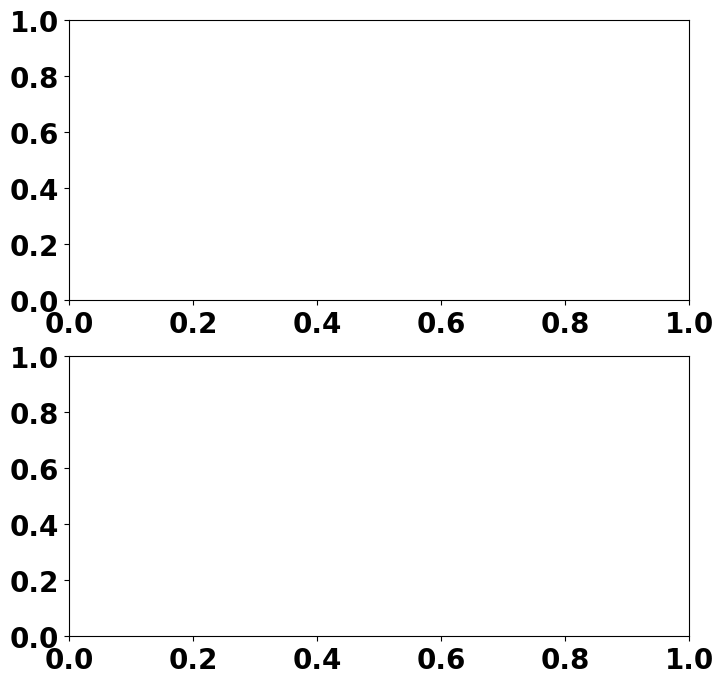

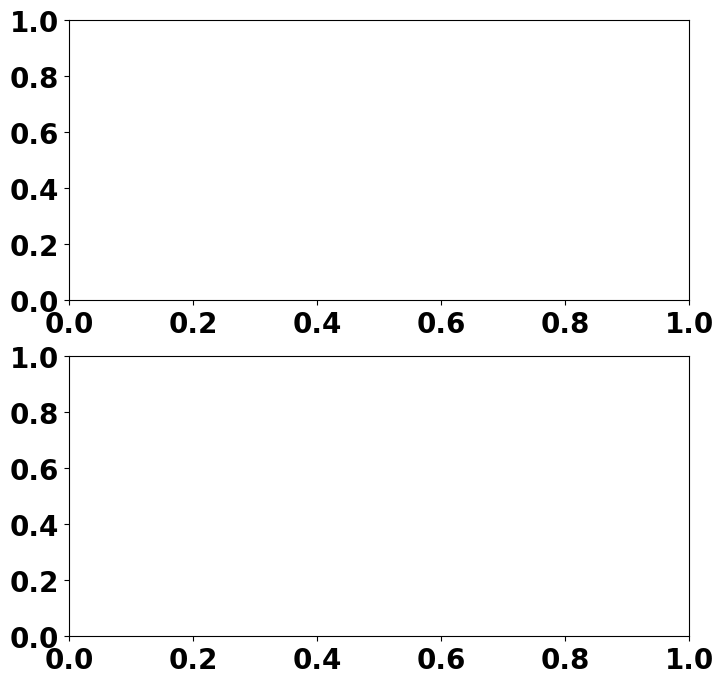

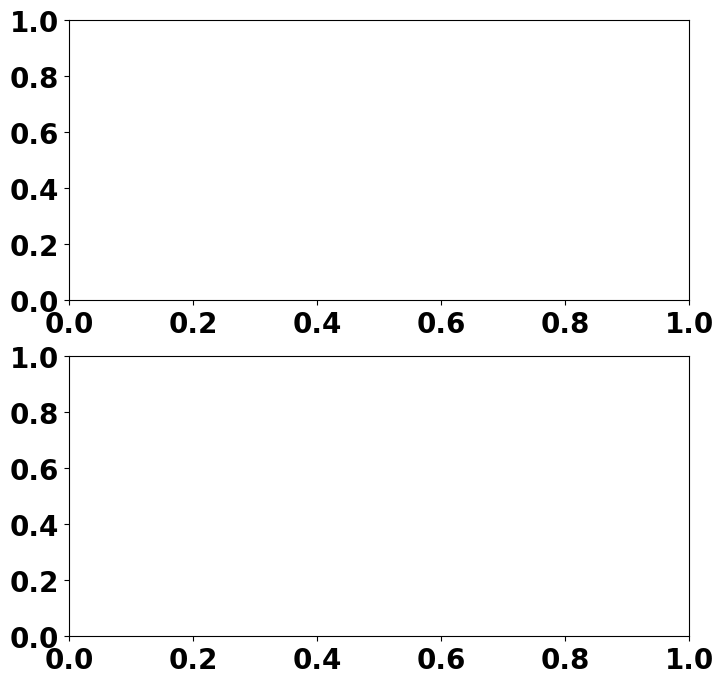

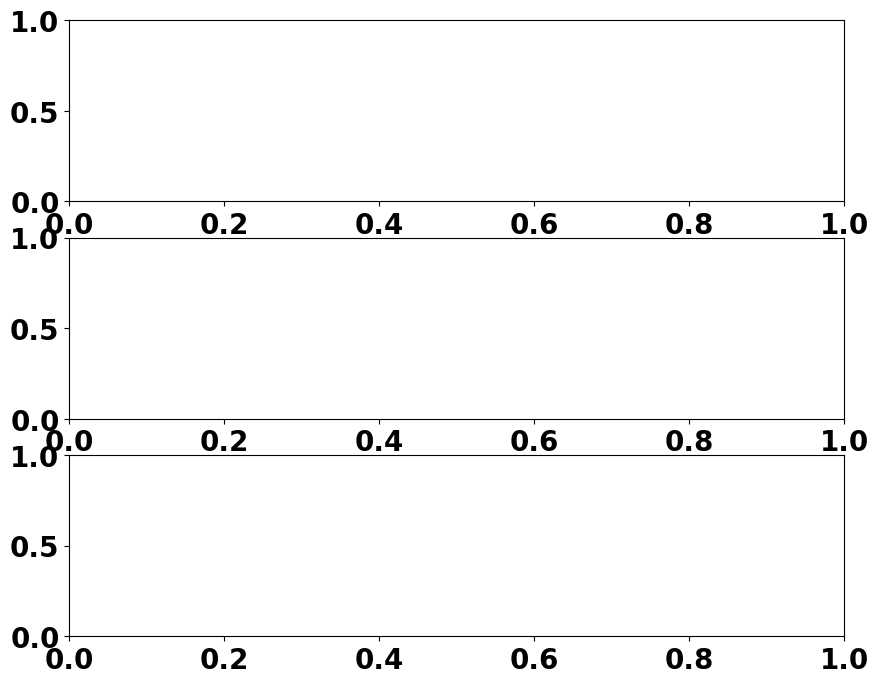

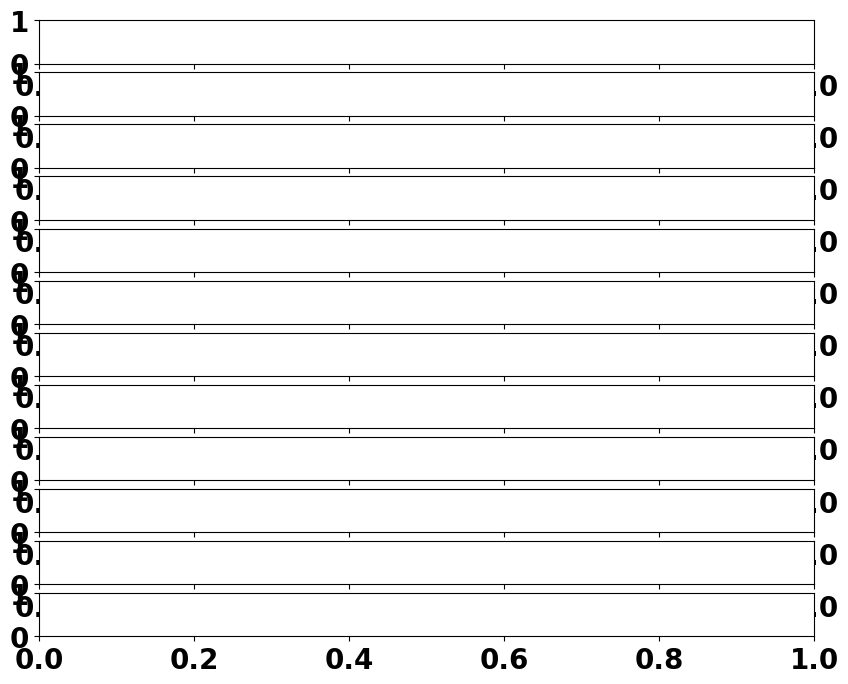

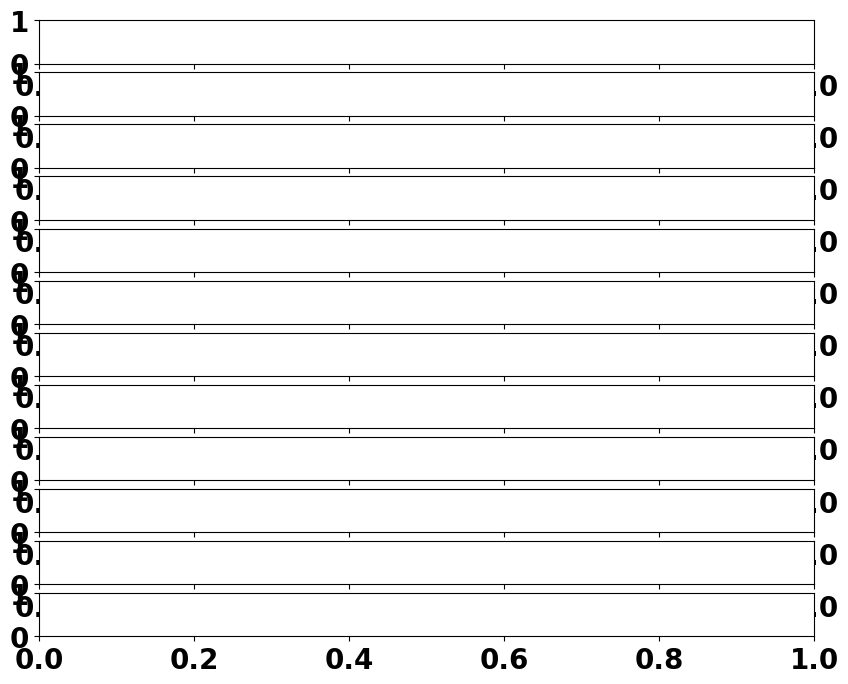

In [ ]:
if todo_allchannels:

    if not in_colab:
        %matplotlib qt
    plt.close("all")
    plt.rcParams['axes.facecolor']='white'

    import gc
    gc.collect()
    torch.cuda.empty_cache()

    batch_size = 1
    lr = 0.0001#0.00001#0.0001
    epochs = 10
    do = 0.2 #0.1 #need to prevent overfitting, if noisy reconstruction: decrese do
    activation_name = "tanh" #tanh, relu, learkyrelu etc...
    loss_name = "mse"
    epochs_save_preliminar = 10
    model_type = "ae"# or vae doesn't reconstructs  well
    nchs = 12
    channel = None
    quicktest = False
    sr_type = "convt" # convt for super resolution, None for DCAE without super resolution FIX THIS ERROR
    loss_type = "lr+hr"#"lr+hr"#"lr+hr", "lr" or "hr"
    denoising = False #or false
    label_num = 99
    label = "All"

    kernel_sizes = [[3, 3], [3, 3]]
    out_channels = [[nchs, 128], [256, 1024]] #[[nchs, nchs*16], [nchs*64, nchs]]
    strides = [[1, 1] for i in range(len(kernel_sizes))]# STRIDE 1 CONFERMATO
    kernel_sizes_sr = [[30, 30], [10, 4]]
    str_sr = [[5, 2], [1, 1]] #[[5, 2], [1, 1]]
    of_sr = reverse_listoflist(out_channels)

    if sr_type is None:
        if denoising:
            training_dataloader, _, _, _, _ = get_dataloader(dict_windows_train_lr_n, sub_labels = sub_labels_train, dict_windows_hr = dict_windows_train_lr, label = label, loss_type=loss_type, n_workers = None, channel = channel, quicktest = quicktest, denoising = denoising)
            test_dataloader, to_predict, _, _, _ = get_dataloader(dict_windows_test_lr_n, sub_labels = sub_labels_test, dict_windows_hr = dict_windows_test_lr, loss_type=loss_type, n_workers = None, label = label, channel = channel, quicktest = quicktest, denoising = denoising)
            to_predict = dict_windows_test_lr_n[label][250] #250 is noisy
            to_predict_hr = dict_windows_test_lr[label][250]
        else:
            training_dataloader, _, _, _ = get_dataloader(dict_windows_train_lr_n, sub_labels = None, dict_windows_hr = None, label = label, loss_type=loss_type, n_workers = None, channel = channel, quicktest = quicktest)
            test_dataloader, to_predict, _, _ = get_dataloader(dict_windows_test_lr_n, sub_labels = None, dict_windows_hr = None, loss_type=loss_type, n_workers = None, label = label, channel = channel, quicktest = quicktest)
            if isinstance(to_predict, list):
                to_predict = to_predict[0]
            to_predict_hr = None
    else:
        training_dataloader, _, _, _, _ = get_dataloader(dict_windows_train_lr_n, sub_labels = sub_labels_train,  dict_windows_hr = dict_windows_train_hr, label = label, loss_type=loss_type, n_workers = None, channel = channel, quicktest = quicktest)
        test_dataloader, to_predict, to_predict_hr, _, _ = get_dataloader(dict_windows_test_lr_n, sub_labels = sub_labels_test, dict_windows_hr = dict_windows_test_hr, loss_type=loss_type, n_workers = None, label = label, channel = channel, quicktest = quicktest)
    width = dict_windows_train_lr_n[label].shape[-1]
    img = None

    lr_scheduler = False
    lr_change  = {5: 0.00001}
    model, trainer, model_run = train_1d_model(training_dataloader, width, to_predict, img, label_num, do = do, batch_size=batch_size, model_type = model_type, kernel_sizes = kernel_sizes, outchannels = out_channels, strides = strides, activation_name = activation_name, epochs = epochs, lr = lr, mode = "s", channel = channel, lr_change = lr_change, loss_name = loss_name, epochs_save_preliminar = epochs_save_preliminar, lr_scheduler = lr_scheduler, in_colab = in_colab, loss_type = loss_type, sr_type = sr_type, of_sr =of_sr ,str_sr = str_sr, kernel_sizes_sr = kernel_sizes_sr, to_predict_hr=to_predict_hr, denoising = denoising)

    train_losses = trainer.logger.log["loss"]
    file = open(cwd+sep+'trainlosses_noisy_all.txt', 'w')
    file.write(str(train_losses))

In [ ]:
#!pip install torchprofile

In [ ]:
from torchprofile import profile_macs
macs = profile_macs(model, dict_windows_train[label])
macs

In [19]:
labels = map_superclass_rev.keys()
dict_windows_test_hr = {}
dict_windows_test_lr = {}
dict_windows_train_lr = {}
dict_windows_train_hr = {}
dict_windows_test_lr_n = {}
dict_windows_train_lr_n = {}
path = os.getcwd()+os.sep+"pt_data"+os.sep
for label in labels:

    if label == "All":
        continue

    filename = path + "test_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_test_hr[label] = hr_data

    filename = path + "test_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr_n[label] = lr_data

    filename = path + "test_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_test_lr[label] = lr_data

    filename = path + "train_{}_hr.pt".format(label)
    hr_data = torch.load(filename)
    dict_windows_train_hr[label] = hr_data


    filename = path + "train_{}_50.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr[label] = lr_data

    filename = path + "train_{}_noisy.pt".format(label)
    lr_data = torch.load(filename)
    dict_windows_train_lr_n[label] = lr_data

dict_windows_train = dict_windows_train_lr_n
dict_windows_test = dict_windows_test_lr_n

In [ ]:
dict(model_run.logger.log)

{'loss': [0.011659918937061645,
  0.010075746611682628,
  0.009309099168030532,
  0.00881482339085763,
  0.008475236151226917,
  0.00820929684407283,
  0.00800271278280049,
  0.007831617997051423,
  0.007681965516154225,
  0.007551629028306942],
 'Reconstruction Loss Signal': [0.02037808291804116,
  0.019733307806655442,
  0.019066359819349666,
  0.01858856535387967,
  0.01822606621658604,
  0.01801885726150804,
  0.017777437288783754,
  0.017653875308845882,
  0.017540290459852056,
  0.017387062343748344],
 'Super Resolution Error': [0.011659918937061645,
  0.010075746611682628,
  0.009309099168030532,
  0.00881482339085763,
  0.008475236151226917,
  0.00820929684407283,
  0.00800271278280049,
  0.007831617997051423,
  0.007681965516154225,
  0.007551629028306942]}

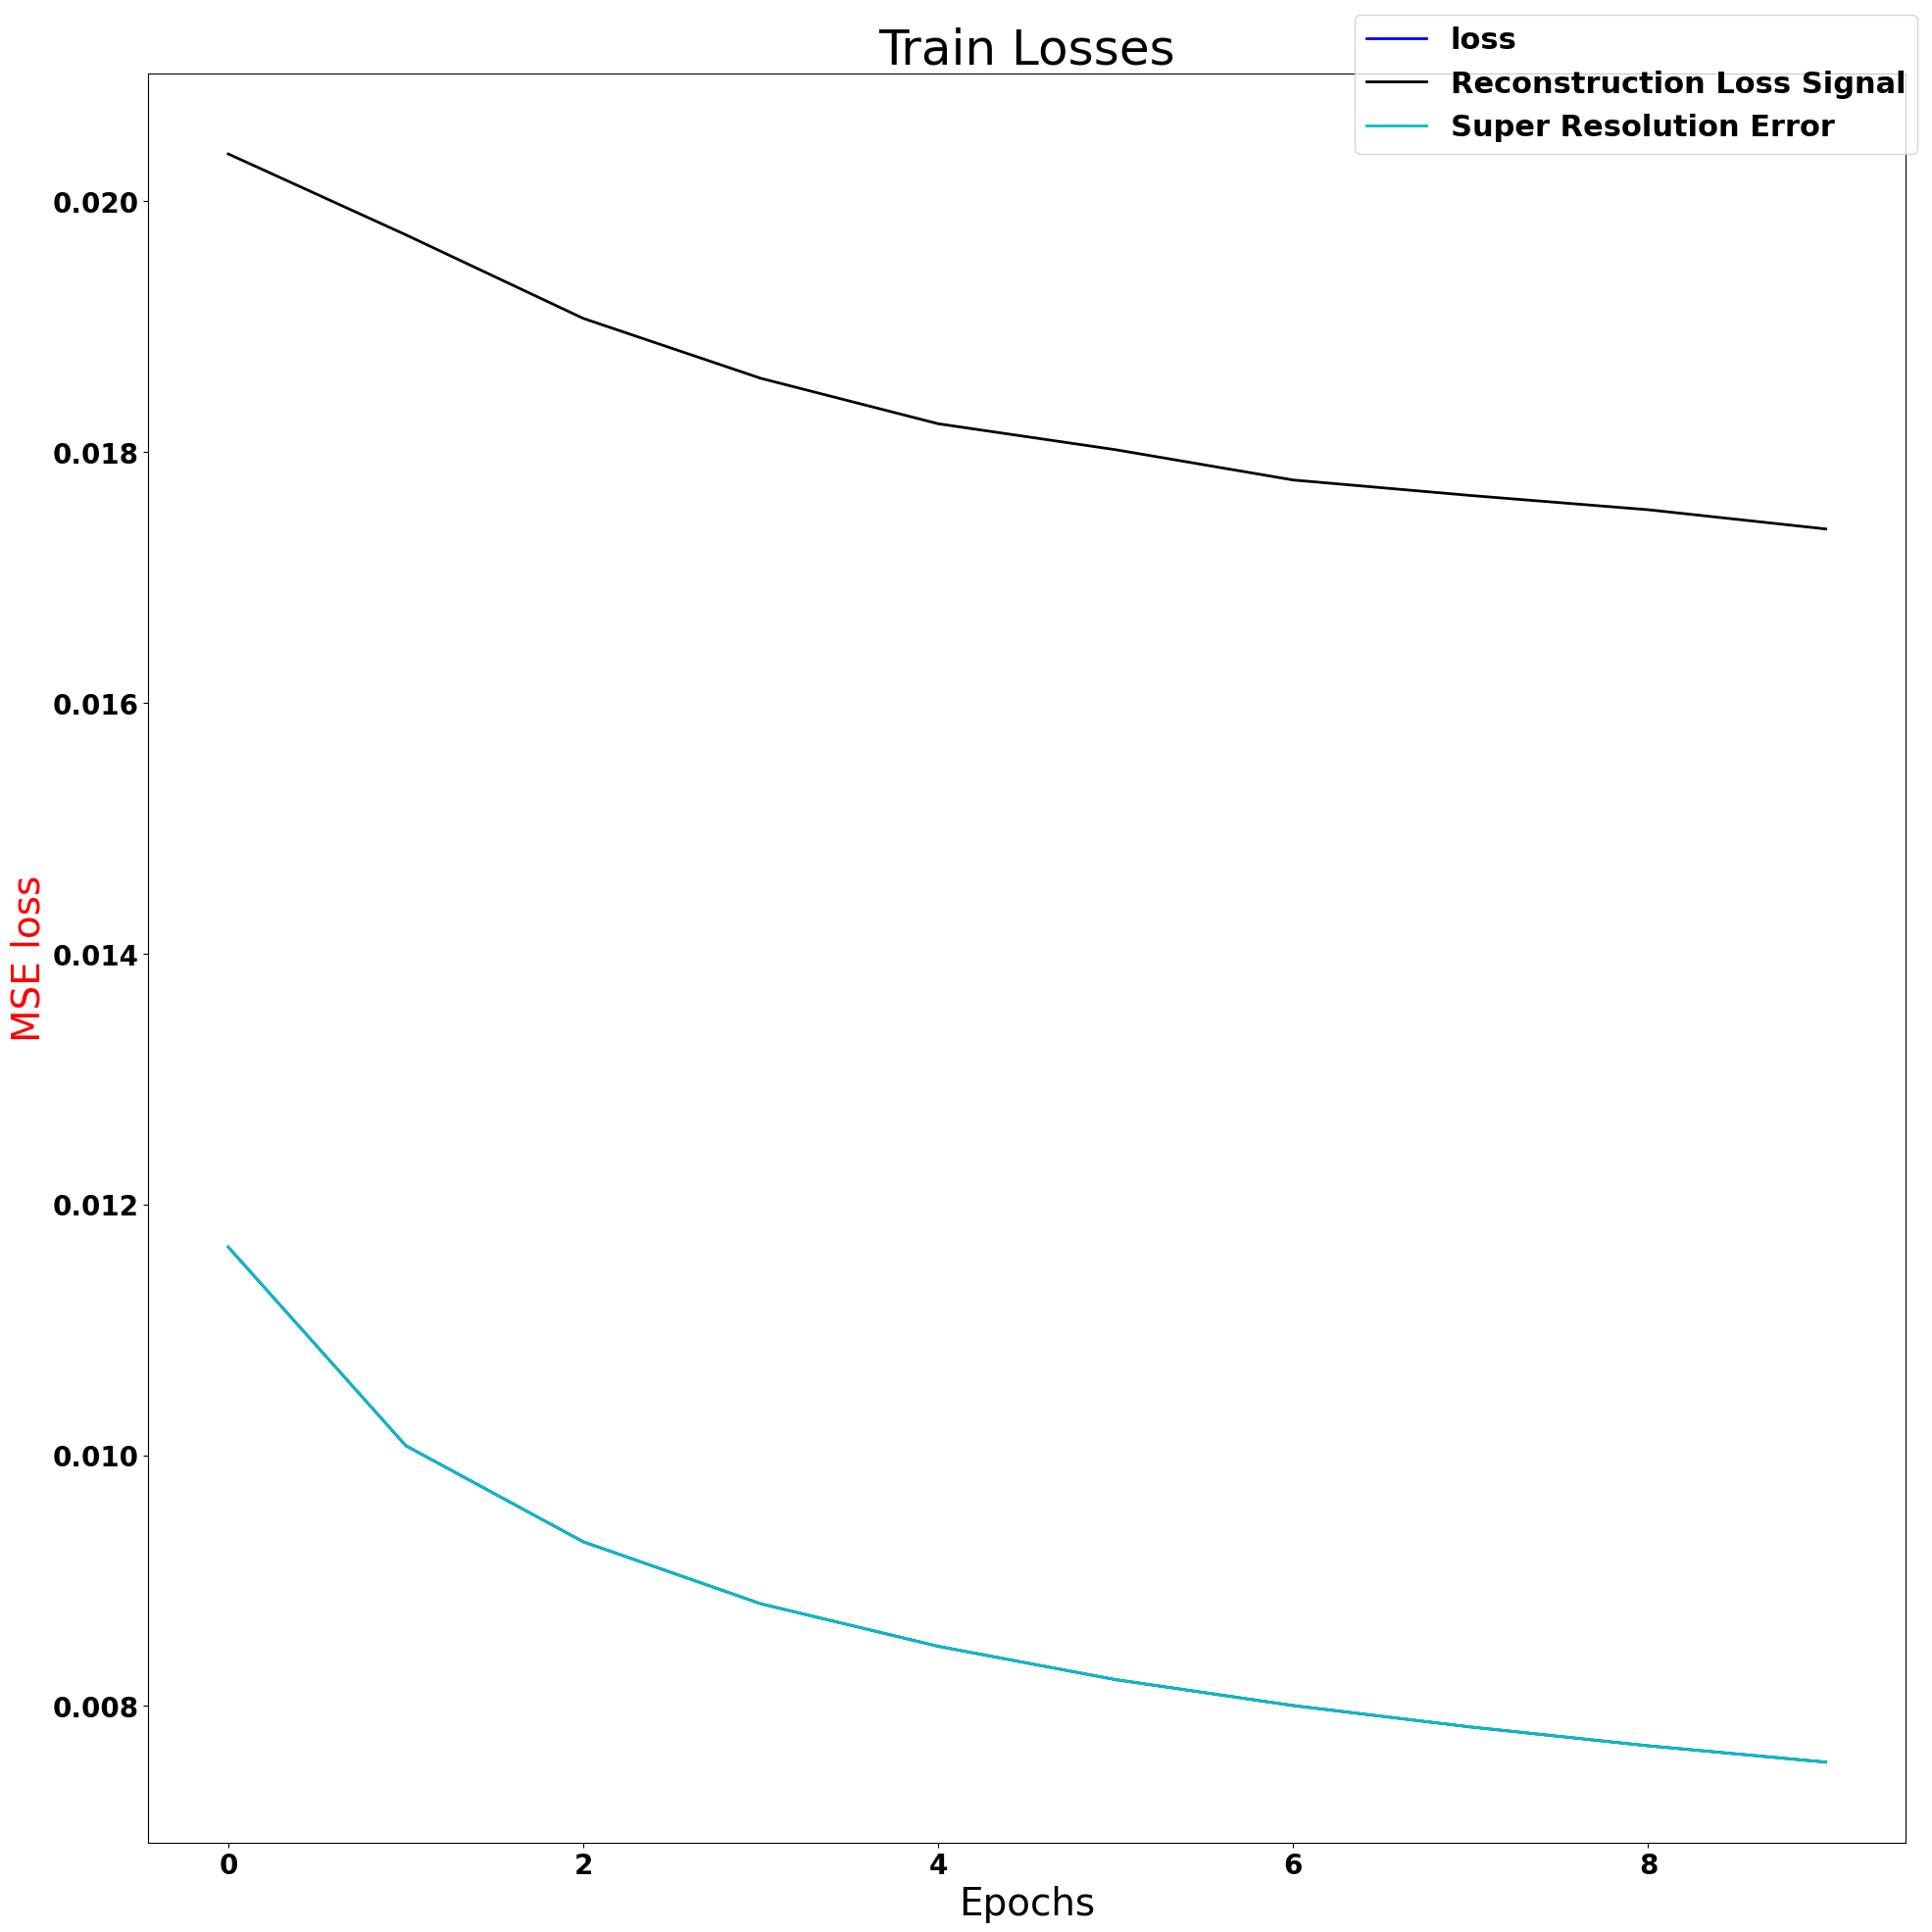

In [ ]:
%matplotlib inline
fig = plt.figure(figsize = (20, 20))
colors = ["b", "k", "c", "r", "g", "m", "y", "pink", "lime", "darkorange", "grey", "saddlebrown", "brown"]

train_losses = dict(model_run.logger.log)

color = "r"

for i, (loss_name, losses) in enumerate(train_losses.items()):
    color = colors[i]
    plt.plot(losses, color, label = loss_name, linewidth = 2)
    plt.ylabel("MSE loss", color="r", size = 28)
    plt.title("Train Losses", size = 36)
    plt.xlabel("Epochs", size = 28)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
fig.legend(loc="upper right")

In [ ]:
torch.save(model, cwd+sep+"models"+sep+"model_all_denoising_lrhr.pt")

if model.sr_type == "convt":
    if denoising:
        if model.loss_type == "lr+hr":
            torch.save(model, cwd+sep+"models"+sep+"model_2_denoising_lrhr.pt")
        else:
            torch.save(model, cwd+sep+"models"+sep+"model_2_denoising_hr.pt")
    else:
        torch.save(model, cwd+sep+"models"+sep+"model_2_nodenoising.pt")
else:
    if denoising:
        torch.save(model, cwd+sep+"models"+sep+"model_2_denoising_nosr.pt")
    else:
        torch.save(model, cwd+sep+"models"+sep+"model_2_nodenoising_nosr.pt")

In [21]:
import os
cwd = os.getcwd()
sep = os.sep
model = torch.load(cwd+sep+"models"+sep+"model_all_denoising_lrhr.pt")
model

VAE1d_SR_multimodal(
  (encoder): Encoder1d(
    (encoder): Sequential(
      (0): EncoderBlock1d(
        (conv1d_in): Conv1d(12, 12, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.2, inplace=False)
        (conv1d_out): Conv1d(12, 128, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.2, inplace=False)
      )
      (1): EncoderBlock1d(
        (conv1d_in): Conv1d(128, 256, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.2, inplace=False)
        (conv1d_out): Conv1d(256, 1024, kernel_size=(3,), stride=(1,))
        (activation_out): Tanh()
        (dropout_out): Dropout(p=0.2, inplace=False)
      )
    )
  )
  (decoder): Decoder1d(
    (decoder): Sequential(
      (0): DecoderBlock1d(
        (conv1d_in): ConvTranspose1d(1024, 1024, kernel_size=(3,), stride=(1,))
        (activation_in): Tanh()
        (dropout_in): Dropout(p=0.2, inpla

In [37]:
import pandas as pd

columns = ["Superclass", "Min MSE", "Max MSE", "Mean MSE(+/-STD)"]
df_all = pd.DataFrame(columns = columns)
df_all.head()

Empty DataFrame
Columns: [Superclass, Min MSE, Max MSE, Mean MSE(+/-STD)]
Index: []

In [38]:
gc.collect()
torch.cuda.empty_cache()

In [39]:
losses_label = {}
for i, label in enumerate(labels):

    print(label)
    loss, losses, sr_windows = validate_single_channel(dict_windows_test_lr_n, dict_windows_test_hr, label, model, channel = None)
    min_ = round(np.min(losses), 5)
    max_ = round(np.max(losses), 5)
    mean_ = round(np.mean(losses), 5)
    std_ = round(np.std(losses), 5)
    values = [label, min_, max_, "{}(+/-){}".format(mean_, std_)]
    df_all.loc[i] = values

    del sr_windows
    losses_label[label] = losses
    print("\n")

CD
490 / 490

HYP
244 / 244

MI


NORM
1926 / 1926

STTC


All


KeyError: 'All'

In [40]:
df_all.set_index("Superclass", inplace = True)
df_all

Min MSE  Max MSE     Mean MSE(+/-STD)
Superclass                                       
CD          0.00033  0.50923  0.00705(+/-)0.02708
HYP         0.00067  0.11041    0.00672(+/-)0.012
MI          0.00046  0.09041  0.00339(+/-)0.00555
NORM        0.00037  0.46488  0.00214(+/-)0.01109
STTC        0.00046  0.08263  0.00276(+/-)0.00542

In [41]:

def plot_super_resolution_final(data_hr, data_sr, channel = None):

    n = data_hr.shape[-1]
    t = np.arange(0, n, 1)

    if channel is None:
        fig, axs = plt.subplots(12, 1, figsize = (20, 80))
        nchs = 12
    else:
        fig, axs = plt.subplots(1, 1, figsize = (20, 10))
        nchs = 1

    sig_or = data_hr
    sig_recons = data_sr

    loss = F.mse_loss(sig_or, sig_recons).item()#device
    fig.suptitle("MSE Loss: {}".format(loss))


    #print(sig_or.shape, sig_recons.shape)
    sig_recons = sig_recons.cpu().detach().numpy()
    sig_or = sig_or.cpu().detach().numpy()

    if channel is None:

        fig.subplots_adjust(wspace=0, hspace=1)
        #fig.tight_layout(pad=0.000)
        for j in range(nchs):

            y_min = min([min(sig_or[0, j, :]), min(sig_recons[0, j, :])])
            y_max = max([max(sig_or[0, j, :]), max(sig_recons[0, j, :])])

            for line in axs[j].get_lines(): # ax.lines:
                line.remove()
            if j == 0:
                axs[j].plot(t, sig_or[0, j, :], "g", label = "high resolution 500H")
                axs[j].plot(t, sig_recons[0, j, :], "b", label =  "super resolution 500Hz")
            else:
                axs[j].plot(t, sig_or[0, j, :], "g")
                axs[j].plot(t, sig_recons[0, j, :], "b")
            axs[j].title.set_text("Channel {}".format(channels_map[j]))
            axs[j].set_ylim([y_min, y_max])

        axs[0].legend(bbox_to_anchor=(0.7, 1.0))

    else:

        y_min = min([min(sig_or[0, channel, :]), min(sig_recons[0, channel, :])])
        y_max = max([max(sig_or[0, channel, :]), max(sig_recons[0, channel, :])])

        for line in axs.get_lines(): # ax.lines:
            line.remove()
        axs.plot(t, sig_or[0, 0, :], "g", label = "high resolution 500Hz")
        axs.plot(t, sig_recons[0, 0, :], "b", label =  "super resolution 500Hz")
        axs.title.set_text("Channel {}".format(channels_map[channel]))
        axs.set_ylim([y_min-0.5, y_max+0.5])
        axs.legend(bbox_to_anchor=(0.7, 1.0))

    return fig

def plot_diff_superresolution(hr_data, sr_data, channel = None):

    loss = F.mse_loss(hr_data.cpu(), sr_data.cpu())
    hr_data = torch.squeeze(hr_data, dim = 0).cpu().detach().numpy()
    sr_data = torch.squeeze(sr_data, dim = 0).cpu().detach().numpy()

    if hr_data.shape != sr_data.shape:
        raise Exception("hr data and sr data must have the same shape but different shapes are given. Shapes {} for hr_data and {} for sr_data were given".format(hr_data.shape, sr_data.shape))
    else:
        width = hr_data.shape[1]
        nchs = hr_data.shape[0]

    if channel is None:
        nchs = 12
        diff = np.zeros((nchs, width))
    else:
        diff = np.zeros((1, width))
        nchs = 1
    for ch in range(nchs):
        hr_data_ch = hr_data[ch]
        sr_data_ch = sr_data[ch]
        diff[ch] = hr_data_ch - sr_data_ch

    fig, axs = plt.subplots(nchs, 1, figsize= (20, 20))
    fig.suptitle("Difference between HR 500 Hz signal and reconstructed SR signal at 500 Hz, MSE : {}".format(loss))
    for ch in range(nchs):
        if nchs > 1:
            axs[ch].plot(diff[ch], "r")
            axs[ch].set_title("Channel {}".format(channels_map[ch]))
        else:
            axs.plot(diff[0], "r")
            axs.set_title("Channel {}".format(channels_map[channel]))
    fig.tight_layout()

    return fig

C:\Users\Utente\AppData\Local\Temp\ipykernel_12788\754899859.py:16: UserWarning: Using a target size (torch.Size([1, 1, 2500])) that is different to the input size (torch.Size([1, 12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(sig_or, sig_recons).item()#device


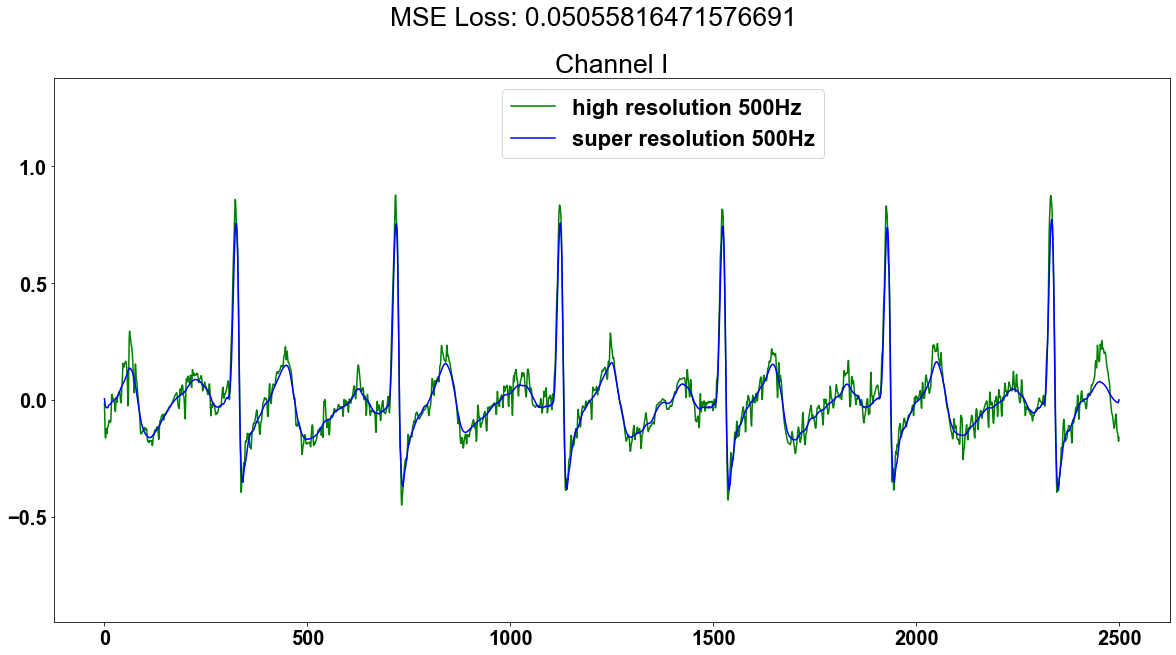

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})

from random import choice
model = model.to(device)
model.eval()
ch = 0
label = "MI"
n = len(dict_windows_test[label])
idx = choice(np.arange(0, n, 1))
lr_data = dict_windows_test_lr_n[label][idx]
hr_data = dict_windows_test_hr[label][idx].cpu()
lr_data = torch.unsqueeze(lr_data, dim=0)
hr_data = torch.unsqueeze(hr_data, dim=0)
pred = model([lr_data, None, None])
sr_data = pred[1]
sr_data = torch.unsqueeze(sr_data, dim=0)
temp_hr= hr_data[:, ch, :]
temp_sr = sr_data[:, ch, :].cpu()
#temp_hr = torch.unsqueeze(temp_hr, dim=0)
temp_sr = torch.unsqueeze(temp_sr, dim=0)
fig = plot_super_resolution_final(temp_hr, temp_sr, channel = ch)

In [ ]:
label = "All"
dict_windows_train_lr_n = {}
dict_windows_test_lr_n = {}
dict_windows_train_hr = {}
dict_windows_test_hr = {}

dict_windows_train_lr_n["All"] = X_train_lr
dict_windows_test_lr_n["All"] = X_test_lr
dict_windows_train_hr["All"] = X_train_hr
dict_windows_test_hr["All"] = X_test_hr

In [ ]:
idxs = np.argsort(losses)[::-1]
sorted_losses = np.array(losses)[idxs]
sr_windows = torch.stack(sr_windows)
sr_windows = torch.squeeze(sr_windows, dim = 1).cpu()
sr_windows_sorted = np.array(sr_windows.detach().numpy())[idxs]
k = 10
idxs[:k], sorted_losses[:k]

(array([489, 355, 354,   7,   6, 434, 435, 372, 459, 268], dtype=int64),
 array([0.50892806, 0.34726843, 0.31356573, 0.24328922, 0.22237626,
        0.14101538, 0.12824665, 0.09683789, 0.09397063, 0.09268203]))

C:\Users\Utente\AppData\Local\Temp\ipykernel_12788\1583726088.py:13: UserWarning: Using a target size (torch.Size([1, 12, 2500])) that is different to the input size (torch.Size([12, 2500])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = F.mse_loss(sr_data, hr_data)


489 tensor(0.5089, device='cuda:0', grad_fn=<MseLossBackward0>)


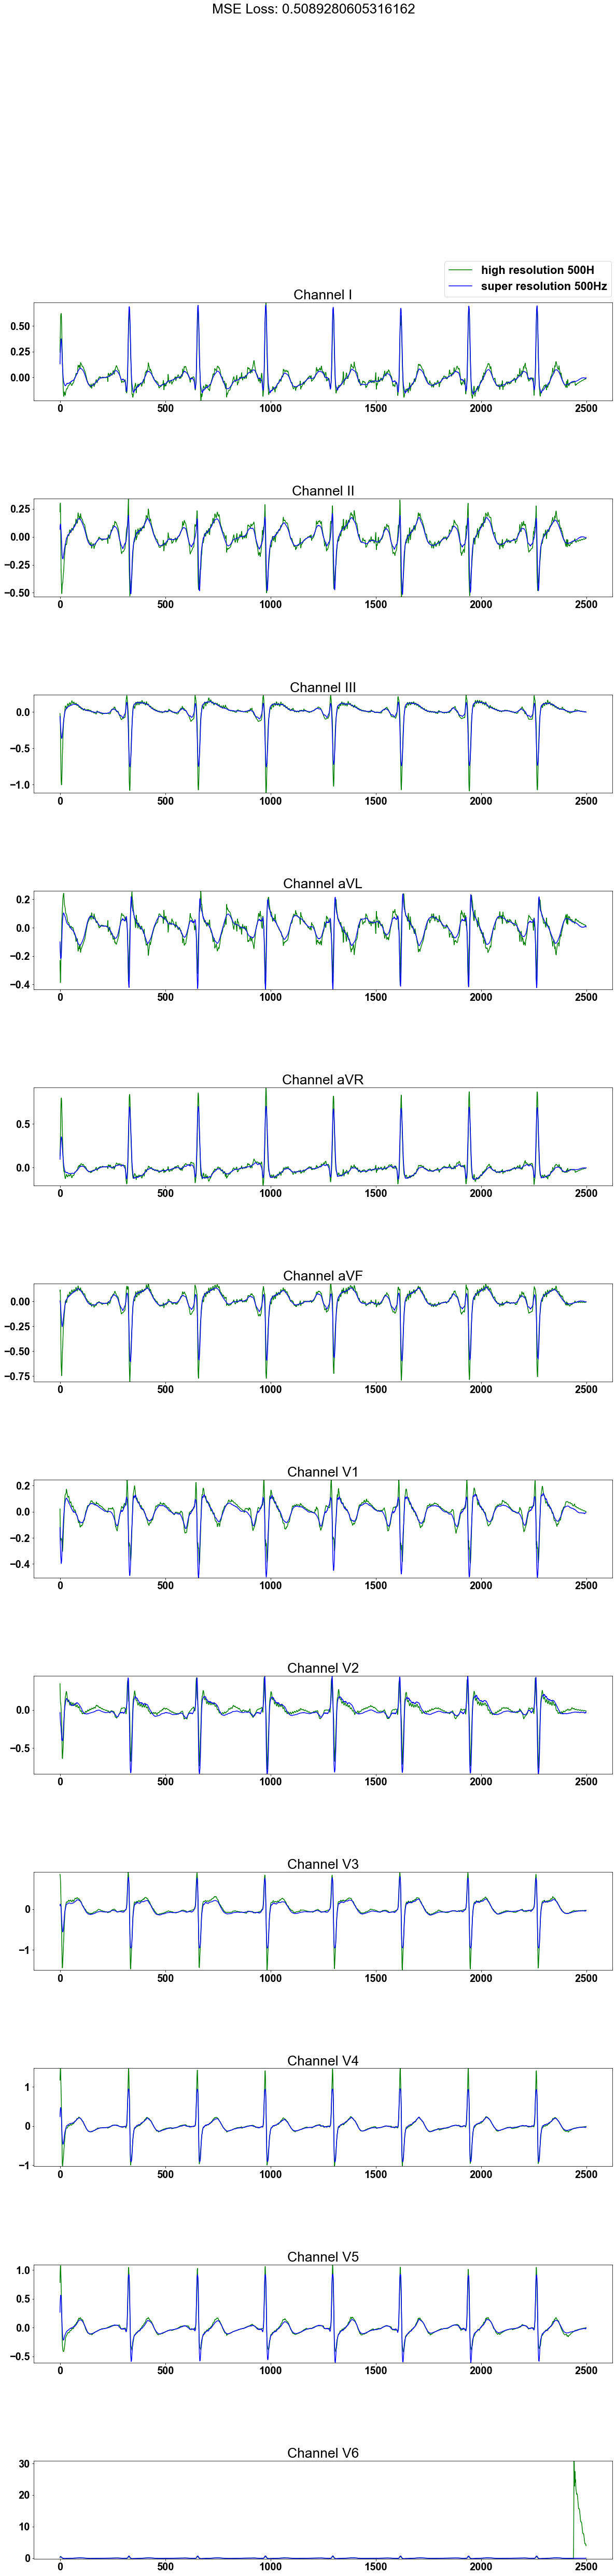

In [ ]:
%matplotlib inline
from random import choice
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
model.eval()
model = model.to(device)
idx = idxs[0]

label = "All"
lr_data = dict_windows_test_lr_n[label][idx]
hr_data = dict_windows_test_hr[label][idx]
sr_data = model([lr_data, None, None, None])[1].to(device)
loss = F.mse_loss(sr_data, hr_data)
print(idx, loss)

ch = None
sr_data = torch.unsqueeze(sr_data, dim = 0)
fig = plot_super_resolution_final(hr_data, sr_data, channel = ch)#channels_map[ch])

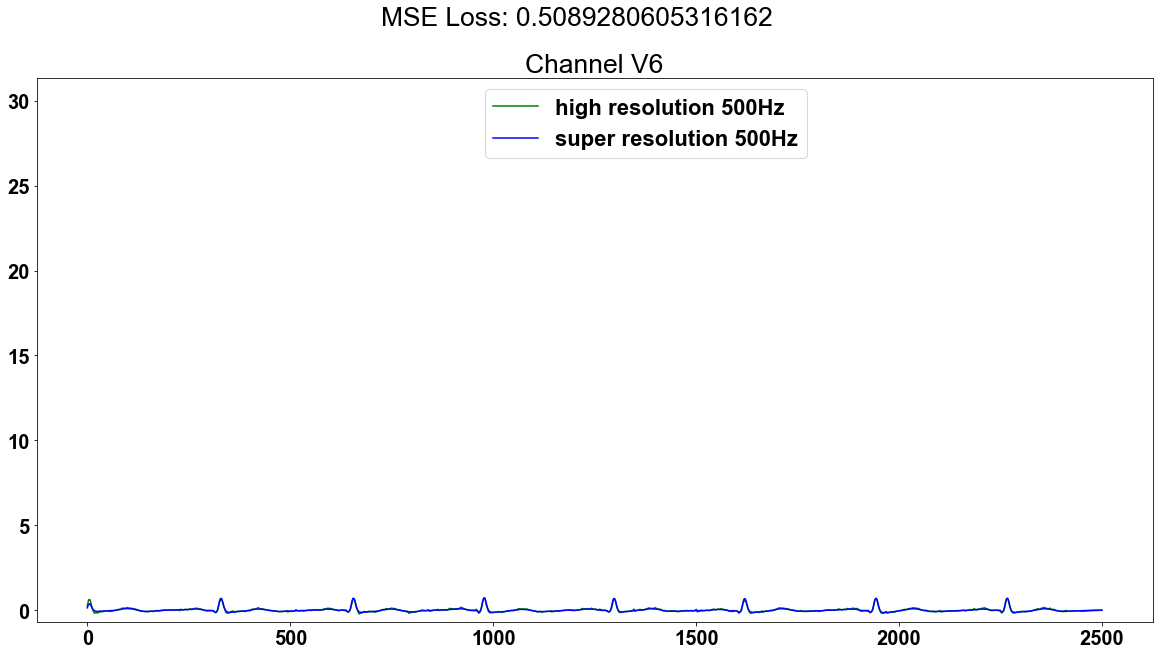

In [ ]:
fig = plot_super_resolution_final(hr_data, sr_data, channel = 11)

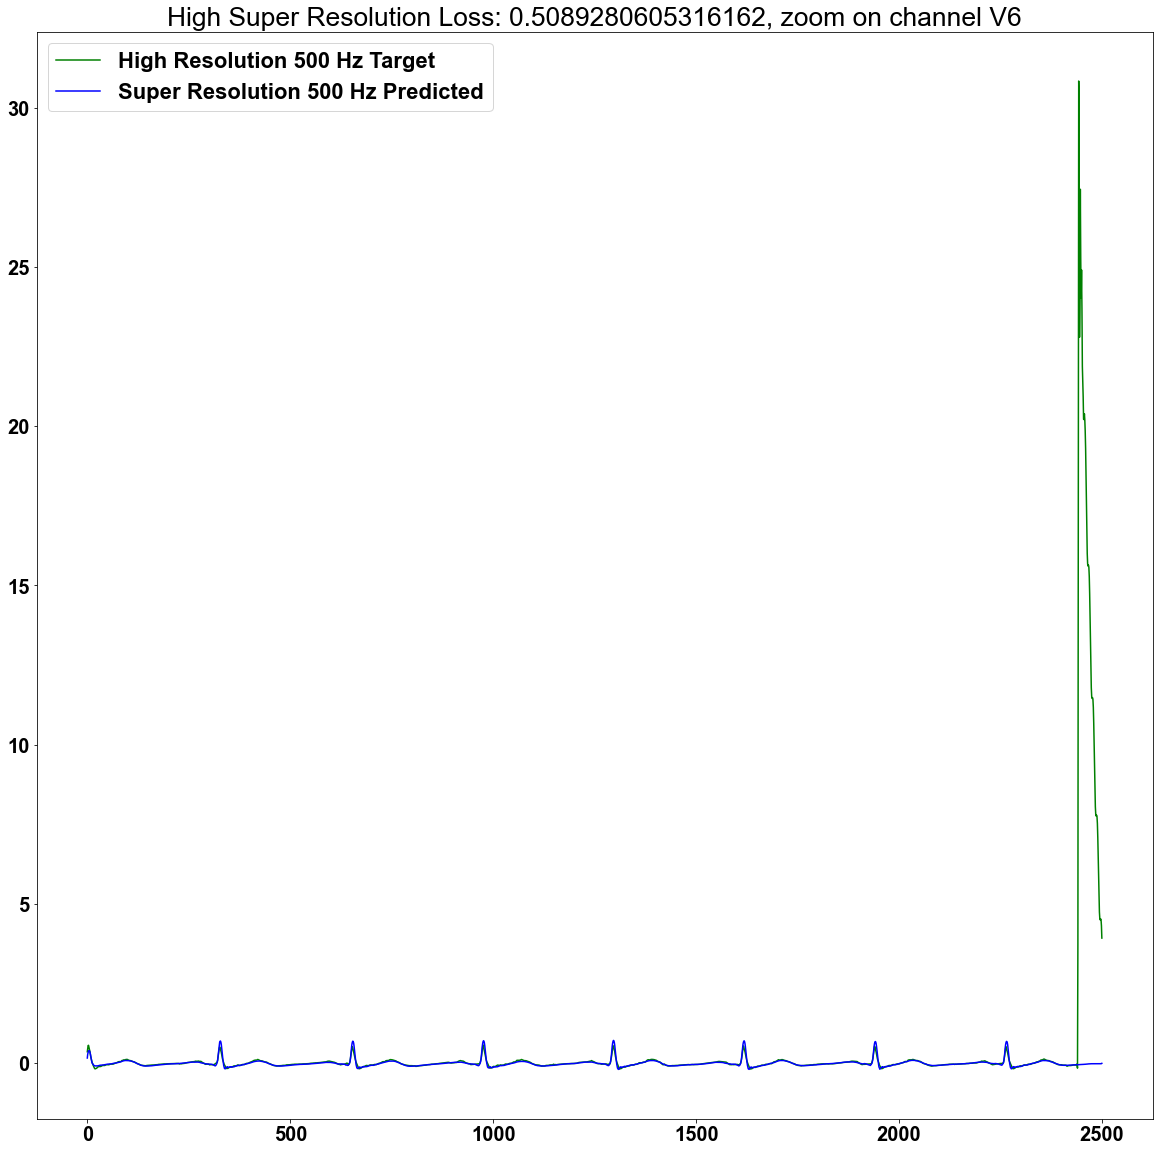

In [ ]:
fig = plt.figure(figsize=(20, 20))
ch = 11
plt.title("High Super Resolution Loss: {}, zoom on channel {}".format(loss, channels_map[ch]))
plt.plot(hr_data[0, ch, :].cpu().detach().numpy(), "g", label = "High Resolution 500 Hz Target")
plt.plot(sr_data[0, ch, :].cpu().detach().numpy(), "b", label = "Super Resolution 500 Hz Predicted")
plt.legend()
#label = "CD"
#fig.savefig("highsrloss_window{}_label{}.png".format(idx, label))

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.graph_objects as go

#visualize latent space
def latentspace_visualize(valid_loader, model, step=0, show=False, mode = "s", device ="cuda"):

    model.eval() # Switch the model to evaluation mode


    cwd = os.getcwd()+os.sep
    path = cwd+"LatentSpace"
    if not os.path.exists(path):
        os.mkdir(path)

    labels = {}
    points = {}

    for i, data in enumerate(valid_loader):

        if mode == "s":
            img, _, label, sublabel = [d.to(device) for d in data]
        if mode == "w":
            img, _, _, _, label, sublabel = [d.to(device) for d in data]

        sublabel = sublabel.item()
        if sublabel not in labels.keys():
            labels[sublabel] = []
        if sublabel not in points.keys():
            points[sublabel] = []
        # We only need to encode the validation images
        proj = model.encode(img)
        proj = proj.detach().cpu().numpy()
        points[sublabel].append(proj)
        labels[sublabel].append(sublabel)
        del img, label

    print(np.array(points[sublabel]).shape, sublabel)
    #fig, ax = plt.subplots(figsize=(40, 20) if not show else (8, 8))
    fig = go.Figure()
    colors = ["red", "green", "blue", "yellow", "black", "pink", "magenta", "purple"]
    for i, (label, values) in enumerate(points.items()):

        #trf = PCA(n_components=2)
        trf = TSNE(n_components=2, perplexity=1)

        values = np.array(values)
        values = trf.fit_transform(values)
        c = colors[i]
        #print(points.shape, len(label_idcs))
        # Creating a scatter plot

        #scatter = ax.scatter(x=values[:, 0], y=values[:, 1], s=2.0,
        #        c=c, label = label, alpha=0.9, zorder=2)
        fig.add_trace(go.Scatter(x=values[:, 0], y=values[:, 1], mode = 'markers', marker_color = c,))

    #ax.spines["right"].set_visible(False)
    #ax.spines["top"].set_visible(False)

    if show:
    #    ax.grid(True, color="lightgray", alpha=1.0, zorder=0)
    #    plt.legend()
        fig.show()
    else:
        # Do not show but only save the plot in training
    #    plt.savefig(f"{path}/Step_{step:03d}.png", bbox_inches="tight")
    #    plt.close() # don't forget to close the plot, or it is always in memory
        model.train()

# convert image sequence to a gif file
def save_gif():

    frames = []
    cwd = os.getcwd()+os.sep
    path = cwd+"LatentSpace"
    imgs = sorted(os.listdir(path))

    for im in imgs:
        new_frame = Image.open(path+ os.sep + im)
        frames.append(new_frame)

    frames[0].save("latentspace.gif", format="GIF",
                     append_images=frames[1:],
                     save_all=True,
                     duration=200, loop=0)

In [ ]:
sub_labels_test["All"]

tensor([0, 0, 0,  ..., 4, 4, 4])

In [ ]:
test_dataloader, _, _, _, _= get_dataloader(dict_windows_test_lr_n, dict_windows_test_hr, sub_labels_test, label = "All")

(568, 185856) 4


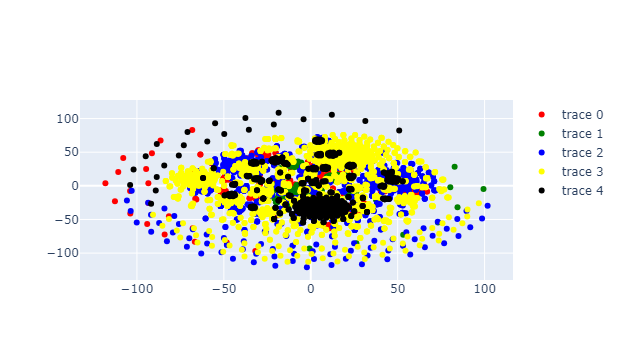

In [ ]:
latentspace_visualize(test_dataloader, model.to(device), step=0, show=True, device = device, mode = "s")

In [ ]:
loss_type = "lr+hr"
channel = None

In [ ]:
test_dataloader, to_predict, to_predict_hr, _, _ = get_dataloader(dict_windows_test_lr, dict_windows_test_hr, sub_labels_test, label = "All")

KeyError: 'All'

In [ ]:
latentspace_visualize(test_dataloader, model.to(device), step=0, show=True, device = device, mode = "s")

In [ ]:
#%matplotlib inline
print(label)
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 22})
idx = 0
to_predict_lr = dict_windows_test_lr_n[label][idx][0, :, :]
to_predict_hr = dict_windows_test_hr[label][idx][0, :, :]

channel = "All Channels"
if channel != "All Channels":
  to_predict_lr = to_predict_lr[channel, :]
  to_predict_hr = to_predict_hr[channel, :]
  to_predict_hr = torch.unsqueeze(to_predict_hr, dim = 0)
  to_predict_lr = torch.unsqueeze(to_predict_lr, dim = 0)
  fig, ax = plt.subplots(1, 1, figsize = (30, 30))
  plot_prediction(model, to_predict_lr, label, fig, ax, 1, to_predict_hr = to_predict_hr)#[0, channel, :]

else:

  fig, axs = plt.subplots(12, 1, figsize = (30, 30))
  plot_prediction(model, to_predict_lr,  label, fig, axs, 12,  to_predict_hr = to_predict_hr) #[0, :, :]

In [ ]:
model.sr_type, model.loss_type

In [ ]:
to_predict_lr = dict_windows_test_lr_n[label][idx][0, :, :]
to_predict_hr = dict_windows_test_hr[label][idx][0, :, :]
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
plot_super_resolution(model, to_predict_lr, to_predict_hr, 0, fig, ax, 12, None, "None", None, None)
fig.tight_layout()

In [ ]:
#df_all.to_csv("results/trainMInoise_testNoisediffLabels.csv")

In [42]:
import plotly
import plotly.graph_objects as go


fig = go.Figure()

colors = ["red", "orange", "yellow", "green", "cyan"]
for i, (label, losses) in enumerate(losses_label.items()):

    c = colors[i]
    fig.add_trace(go.Box(y=losses,
            boxpoints='suspectedoutliers', # can also be outliers, or suspectedoutliers, or False
            jitter = 0.2, # add some jitter for a better separation between points
            pointpos= -0.5, # relative position of points wrt box
            name = label,
            line_width = 2,
            line_color='black',
            fillcolor = c
        )
    )

fig.update_layout(autosize = False, width = 800, height = 800, template = "simple_white")
fig.show()

torch.Size([1, 12, 250])
4
Super resolution error: 0.003203574102371931


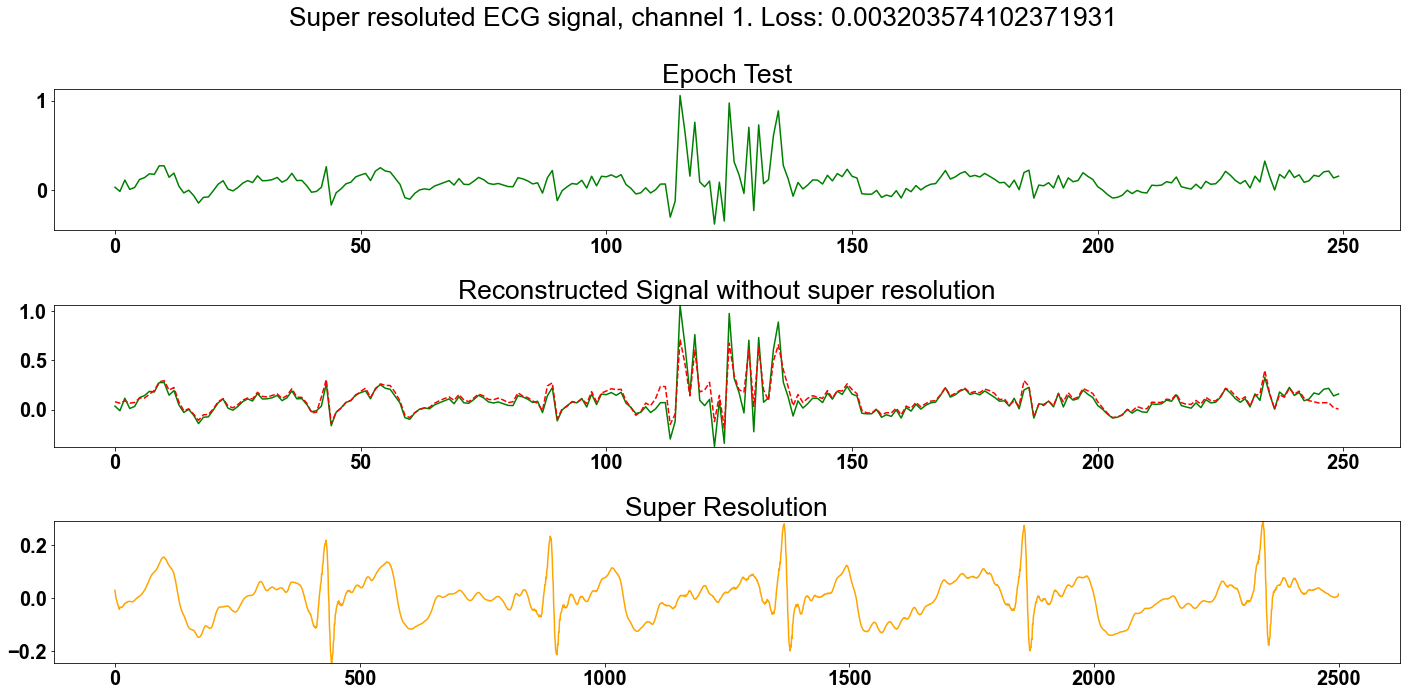

In [ ]:
from torch.nn.functional import mse_loss

label = "NORM"
model = model.to(device)
to_predict_lr = dict_windows_test_lr_n[label][0][0, :, :]
to_predict_hr = dict_windows_test_hr[label][0][0, :, :]
to_predict_lr_clean = dict_windows_test_lr[label][0][0, :, :]
print(to_predict.shape)
sr = model([to_predict_lr, None, None, None])[1]
loss = mse_loss(to_predict_hr, sr)
#print(loss2)
#loss = losses[0]
fig, ax = plt.subplots(3, 1, figsize=(20, 10))
plot_super_resolution(model, to_predict_lr, to_predict_hr, 0, fig, ax, 12, loss, "Test", None, None)
fig.tight_layout()

In [ ]:
gc.collect()

178669

In [ ]:
fig.savefig("lr_vs_lrr_vs_sr.jpg", dpi=600)

In [ ]:
dict_windows_test_lr.keys()

In [ ]:
def resample_signal(data, fs=50, nchs = 12, fin = 50):

    data = data.cpu()

    secs = data.shape[-1]/(fin)
    size = int(fs*secs)

    resampled_data = []
    for ch in range(nchs):
        temp = scipy.signal.resample(x=data[ch, :].detach().numpy(), num=size)
        resampled_data.append(torch.from_numpy(temp))

    resampled_data = torch.stack(resampled_data)

    return resampled_data

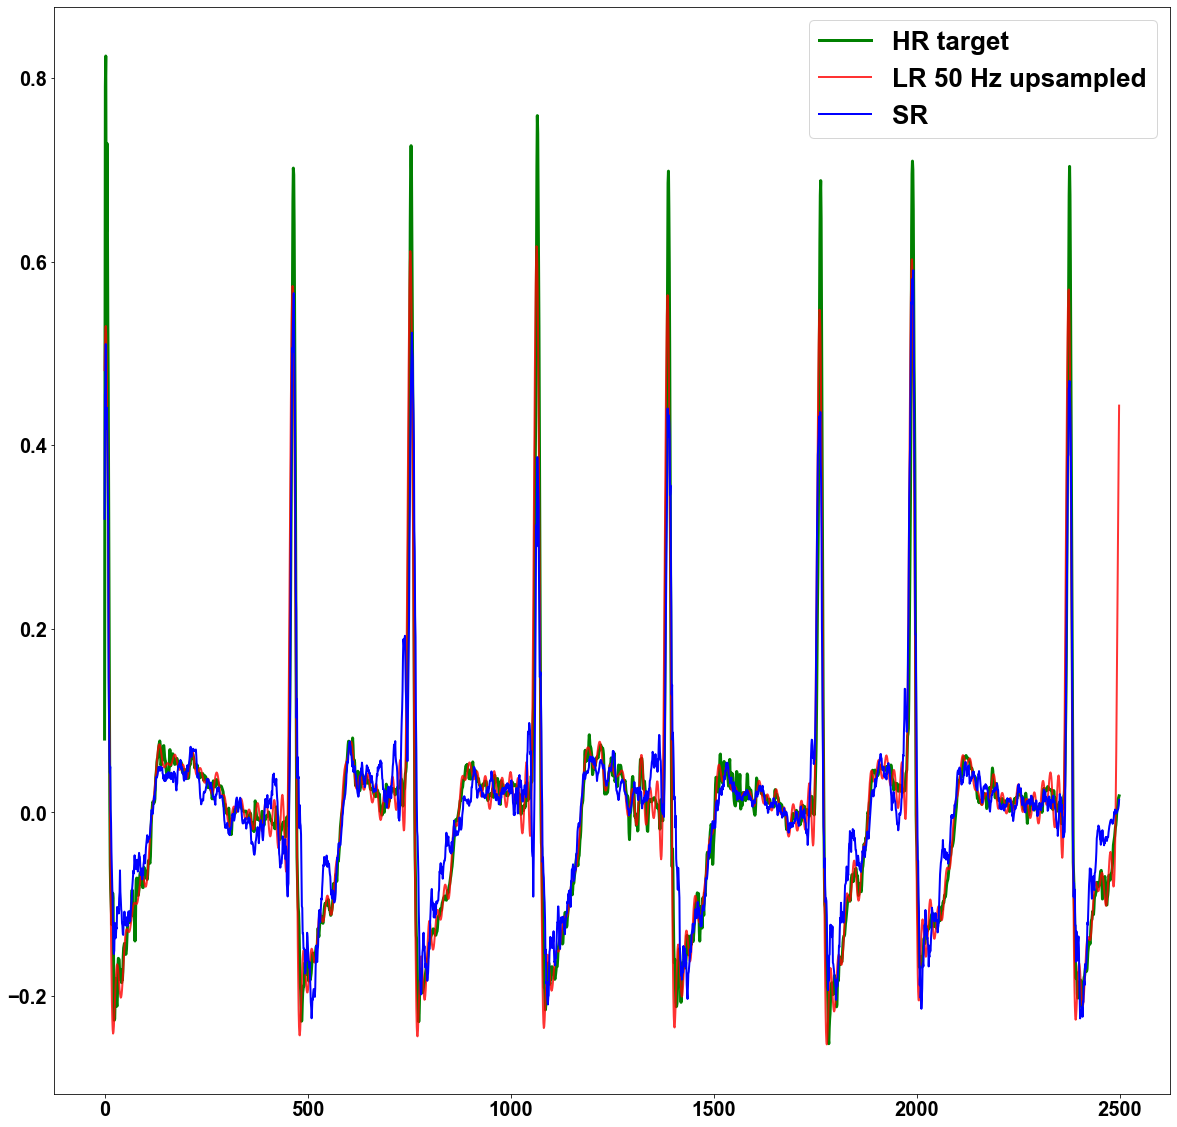

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 26})

idx = 300
label = "MI"
to_predict_lr = dict_windows_test_lr_n[label][idx][0, :, :]
to_predict_hr = dict_windows_test_hr[label][idx][0, :, :]
to_predict_lr_clean = dict_windows_test_lr[label][idx][0, :, :]
sr = model([to_predict_lr, None, None, None])[1]

fig = plt.figure(figsize = (20, 20))
plt.plot(to_predict_hr[0, :].cpu().detach().numpy(),  "g", label = "HR target", linewidth = 3)
up_lr = resample_signal(to_predict_lr, fs = 500, fin = 50)
plt.plot(up_lr[0, :], "r", label = "LR 50 Hz upsampled", linewidth = 2, alpha = 0.8)
plt.plot(sr[0, :].cpu().detach().numpy(), "b", label = "SR", linewidth = 2)
plt.legend()

In [ ]:
fig.savefig("sr_vs_hr.jpg", dpi=600)

In [ ]:
dict_windows_test_lr_n[label].shape

torch.Size([1088, 1, 12, 250])

torch.Size([1, 12, 250])


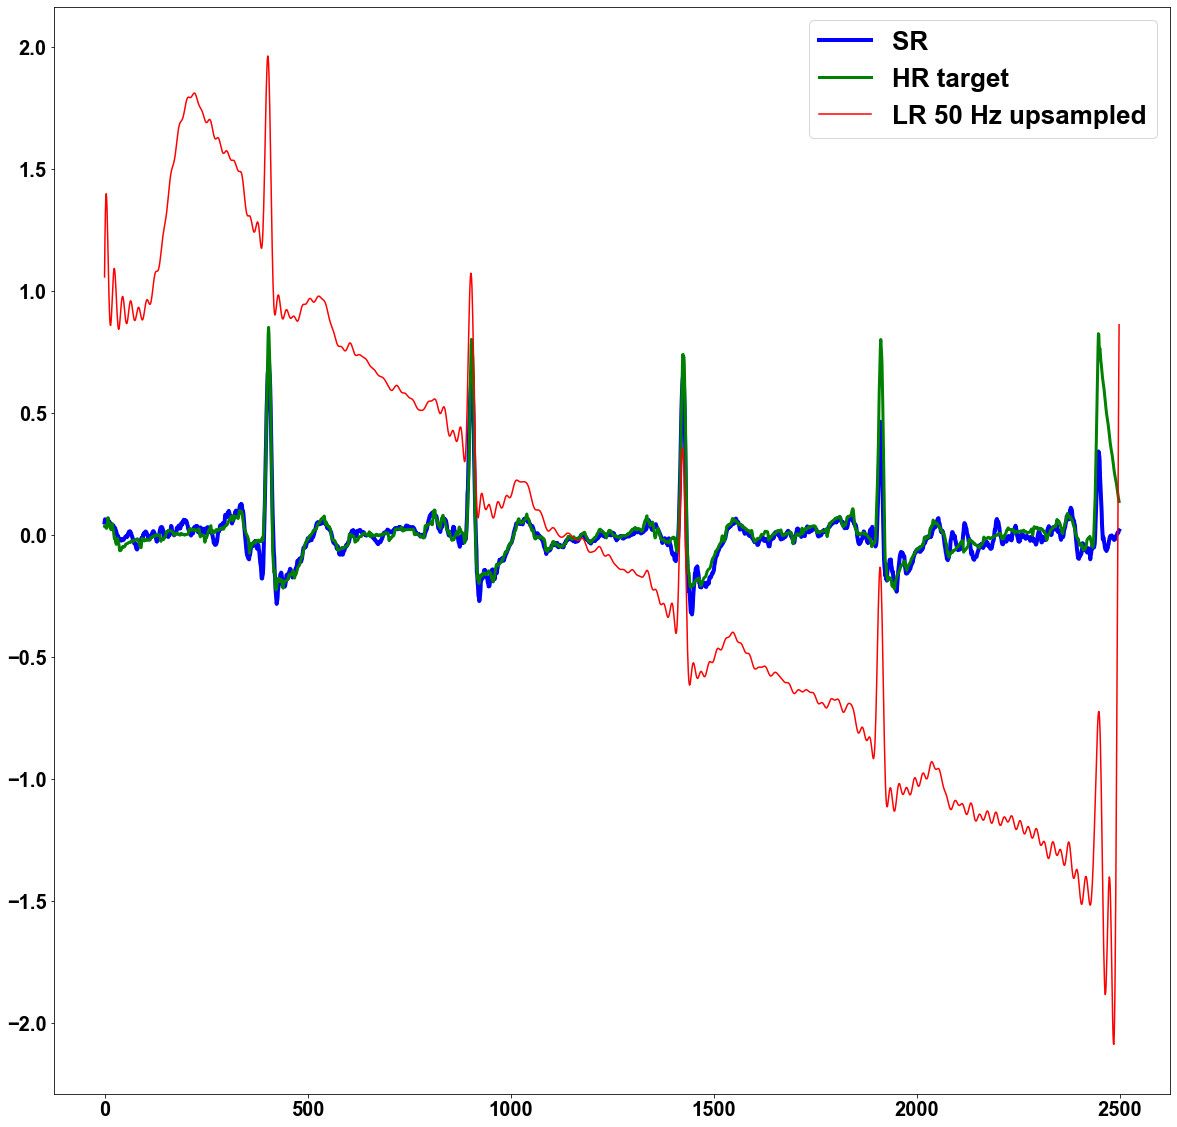

In [ ]:
import random
fig = plt.figure(figsize = (20, 20))
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 26})

n = dict_windows_test_lr_n[label].shape[0]
idx = random.choice(np.arange(0, n-1, 1))
to_predict_lr = dict_windows_test_lr_n[label][idx][0, :, :]
to_predict_hr = dict_windows_test_hr[label][idx][0, :, :]
to_predict_lr_clean = dict_windows_test_lr[label][idx][0, :, :]
print(to_predict.shape)
sr = model([to_predict_lr, None, None, None])[1]
loss2 = mse_loss(to_predict_hr, sr)
plt.plot(sr[0, :].cpu().detach().numpy(), "b", label = "SR", linewidth = 4)
plt.plot(to_predict_hr[0, :].cpu().detach().numpy(),  "g", label = "HR target", linewidth = 3)
up_lr = resample_signal(to_predict_lr, fs = 500, fin = 50)
plt.plot(up_lr[0, :], "r", label = "LR 50 Hz upsampled", alpha = 1)
plt.legend()

In [ ]:
fig.savefig("lrnoise_hr_sr.png", dpi = 600)

In [ ]:
#prepare_training_gif(epochs, epochs_save_preliminar)

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar

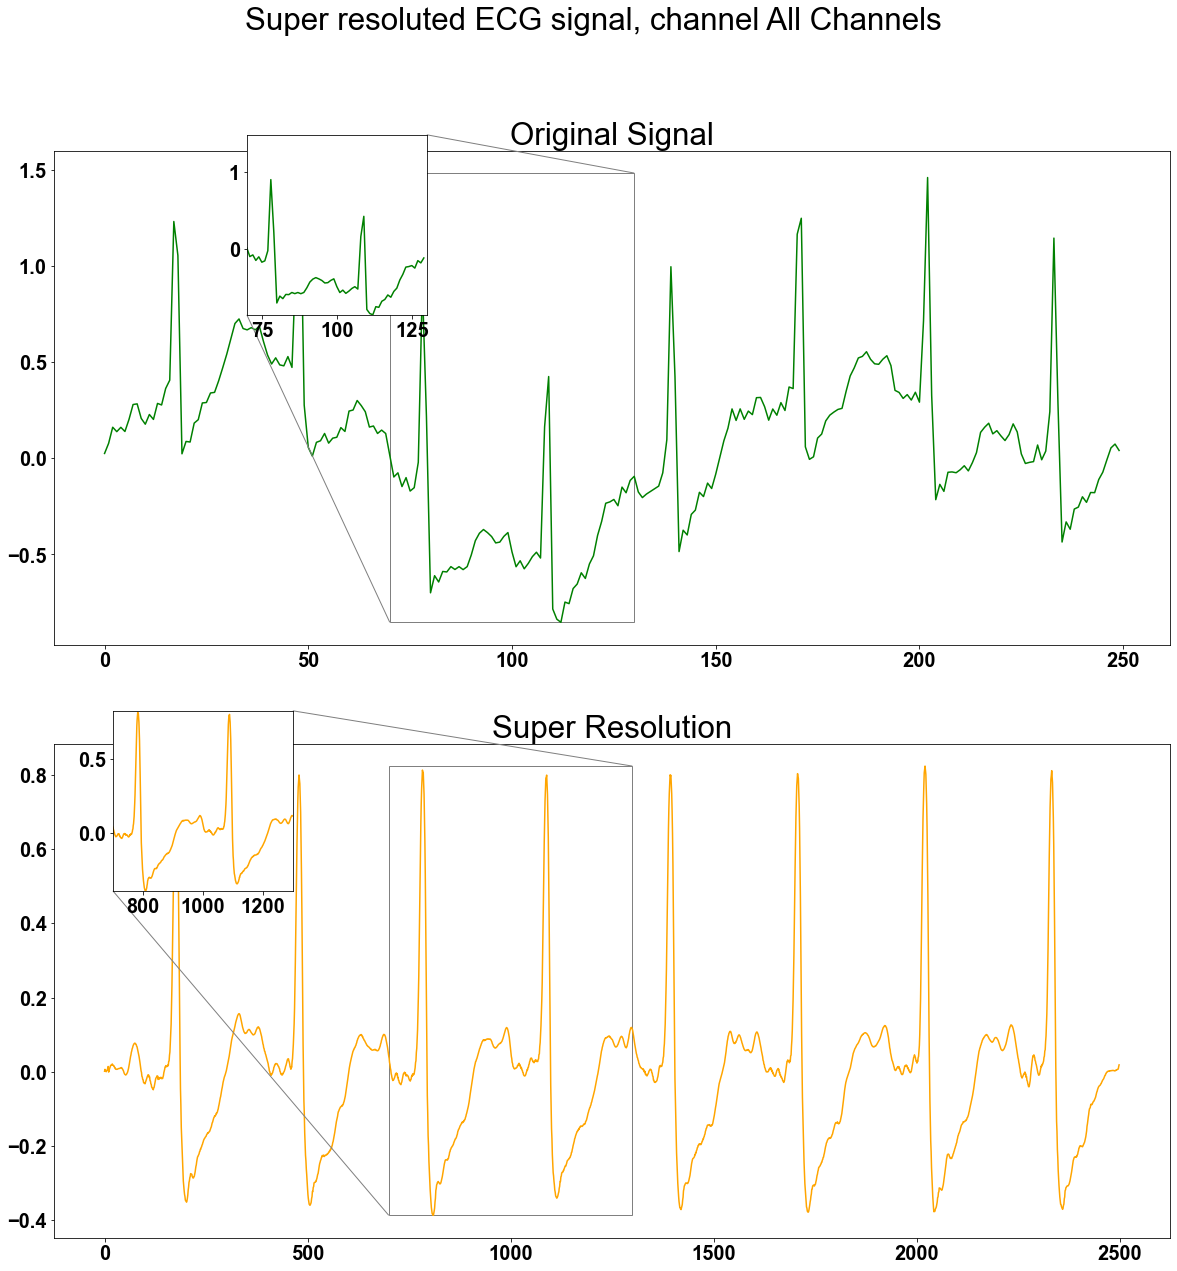

In [ ]:
from mpl_toolkits.axes_grid1.inset_locator import mark_inset, inset_axes

idx = 100
label = "MI"

to_predict_lr = dict_windows_test_lr_n[label][idx][0, :, :]
to_predict_hr = dict_windows_test_hr[label][idx][0, :, :]

channel = "All Channels"
fig, axs = plt.subplots(2, figsize=(20, 20))
if channel == "All Channels":
  channel_m = channel
else:
  channel_m = channels_map[channel]
fig.suptitle("Super resoluted ECG signal, channel {}".format(channel_m))


model = model.to(device)
model.eval()
pred = model([to_predict_lr.to(device), None, None, None])
n1 = to_predict_lr.shape[-1]
t1 = np.arange(0, n1, 1)
sig_or = torch.squeeze(to_predict_lr).cpu().detach().numpy()
sig_sr = torch.squeeze(pred[1]).cpu().detach().numpy()
n2 = sig_sr.shape[-1]
t2 = np.arange(0, n2, 1)

for i in range(2):

    ax = axs[i]

    if i == 1:
        t = t2
        title = "Super Resolution"
        if channel != "All Channels":
            y = sig_sr[:]
        else:
            y = sig_sr[0, :]
        axins = inset_axes(ax, 2.5, 2.5, loc=1, bbox_to_anchor=(.3, 0.5),bbox_transform=fig.transFigure)
        color = "orange"
    else:
        t = t1
        title = "Original Signal"
        if channel != "All Channels":
            y = sig_or[:]
        else:
            y = sig_or[0, :]
        axins = inset_axes(ax, 2.5, 2.5, loc=2, bbox_to_anchor=(.25, 0.9),bbox_transform=fig.transFigure)
        color = "g"

    ax.plot(t, y, color)
    ax.title.set_text(title)

    if i == 0:
        i1, i2 = 70, 130# specify the limits
    else:
        i1, i2 = 70*10, 130*10

    axins.plot(t[i1:i2], y[i1:i2], color)

    axins.set_xlim(t[i1], t[i2]) # apply the x-limits
    axins.set_ylim(min(y), max(y)) # apply the y-limits

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="0.5")

plt.show()

In [ ]:
fig.savefig("super_resolution_zoom.jpg", dpi=600)

(-2.0, 2.0)

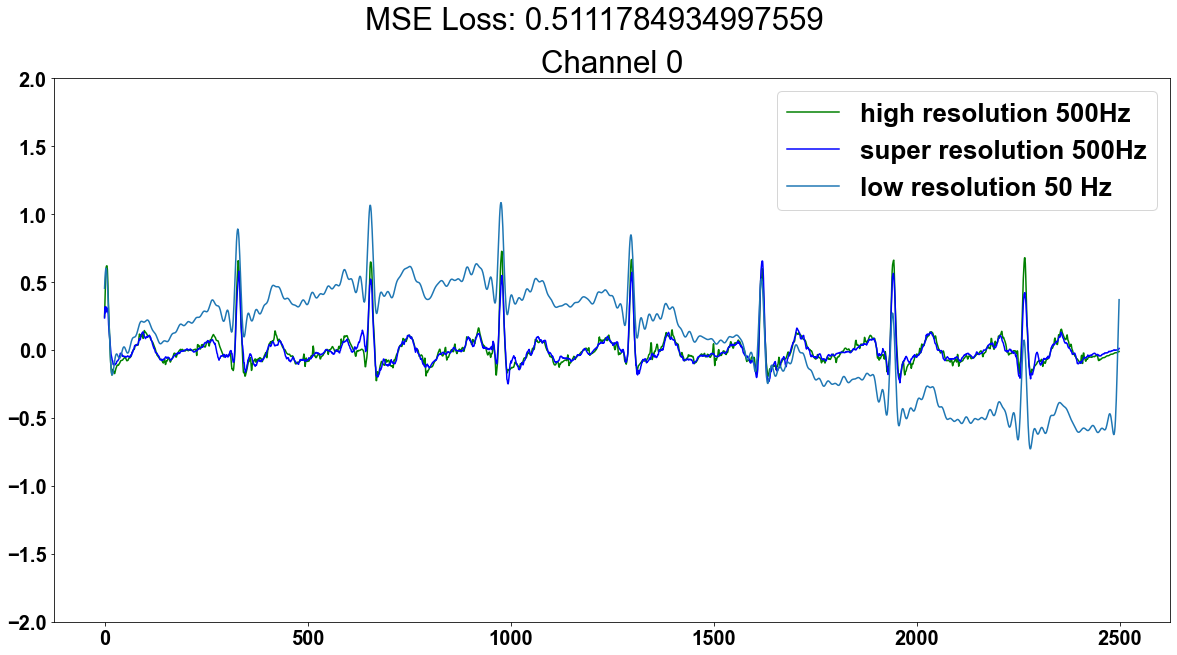

In [ ]:
import random

#label = "MI"
label = "CD"
losses = losses_label[label]
idxs = np.argsort(losses)[::-1]
sorted_losses = np.array(losses)[idxs]

testing_data_hr = dict_windows_test_hr[label]
testing_data_noise = dict_windows_test_lr_n[label]
testing_data_clear = dict_windows_test_lr[label]
ch = 0

n = len(testing_data_hr)
idx = idxs[0]#random.choice(np.arange(0, n, 1))
test_hr = testing_data_hr[idx].cpu()
test_noise = testing_data_noise[idx]
sr_window = model.predict([test_noise, None, None, None])[1].cpu()
test_noise = test_noise.cpu()

if sr_window.ndim == 2:
    sr_window = torch.unsqueeze(sr_window, dim = 0)
fig = plot_super_resolution_final(test_hr, sr_window, channel = ch)

up_lr = resample_signal(test_noise[0, :, :], fs = 500, fin = 50)
plt.plot(up_lr[ch, :], label = "low resolution 50 Hz", alpha = 1)
plt.legend()
plt.ylim([-2, 2])

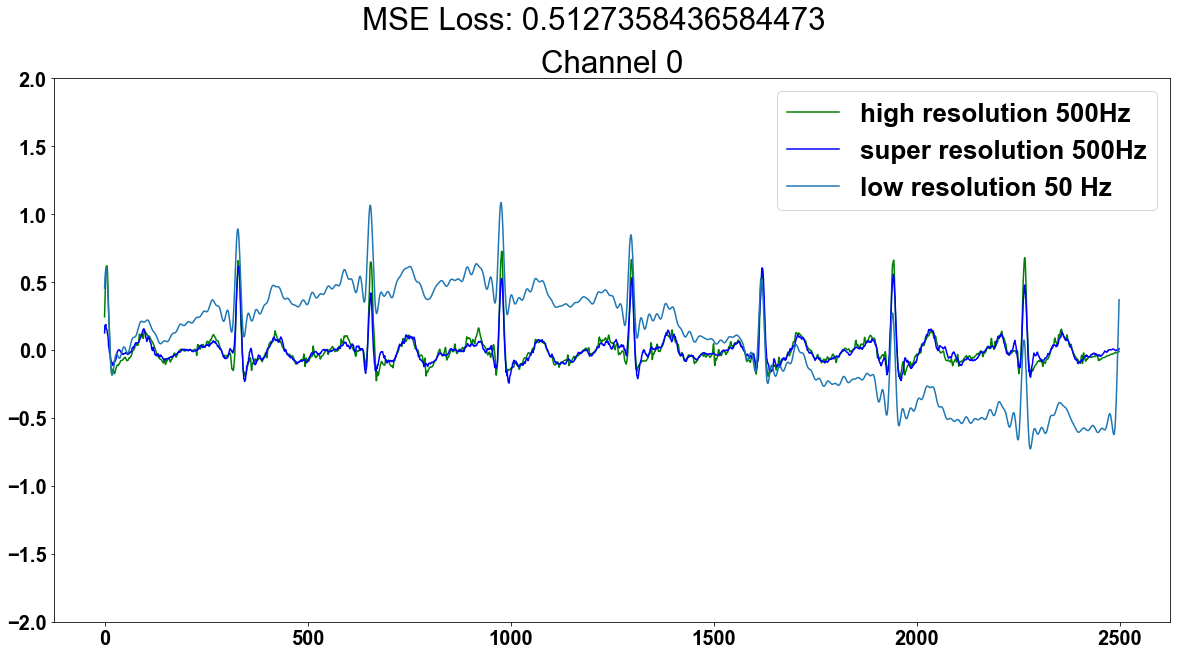

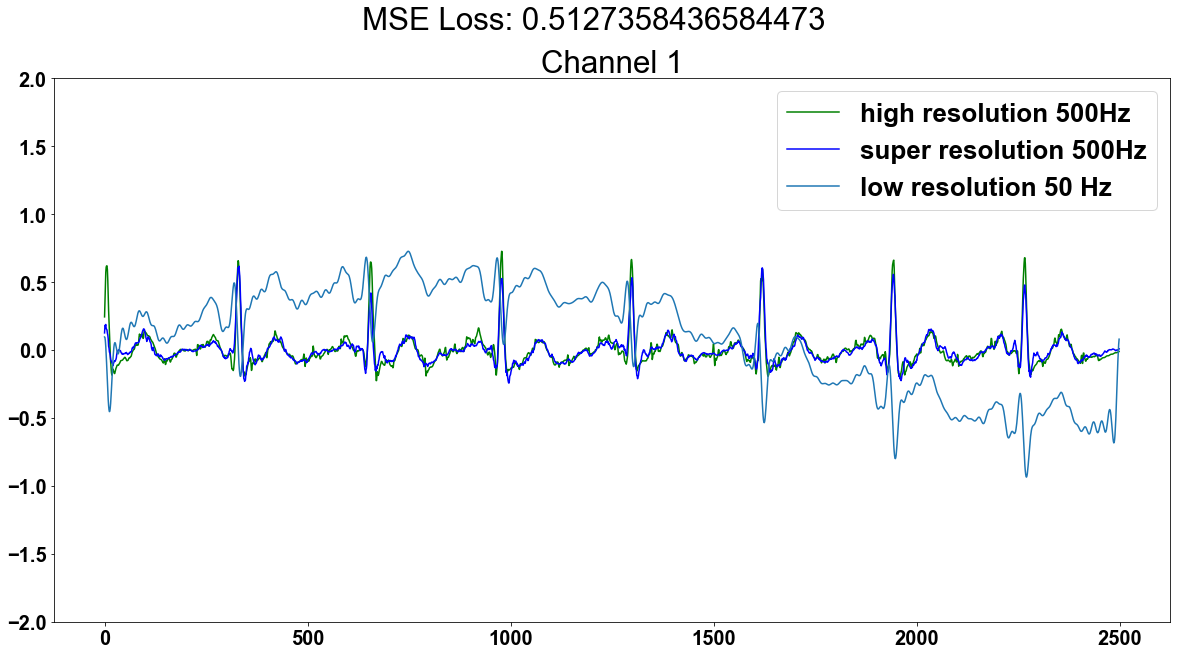

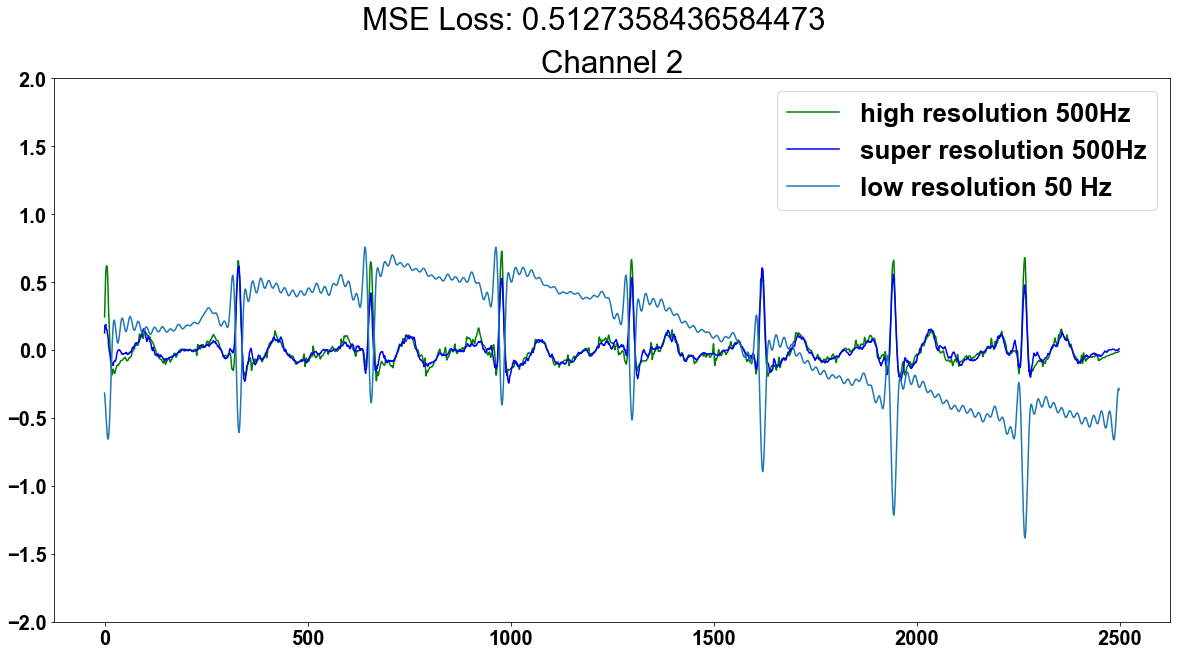

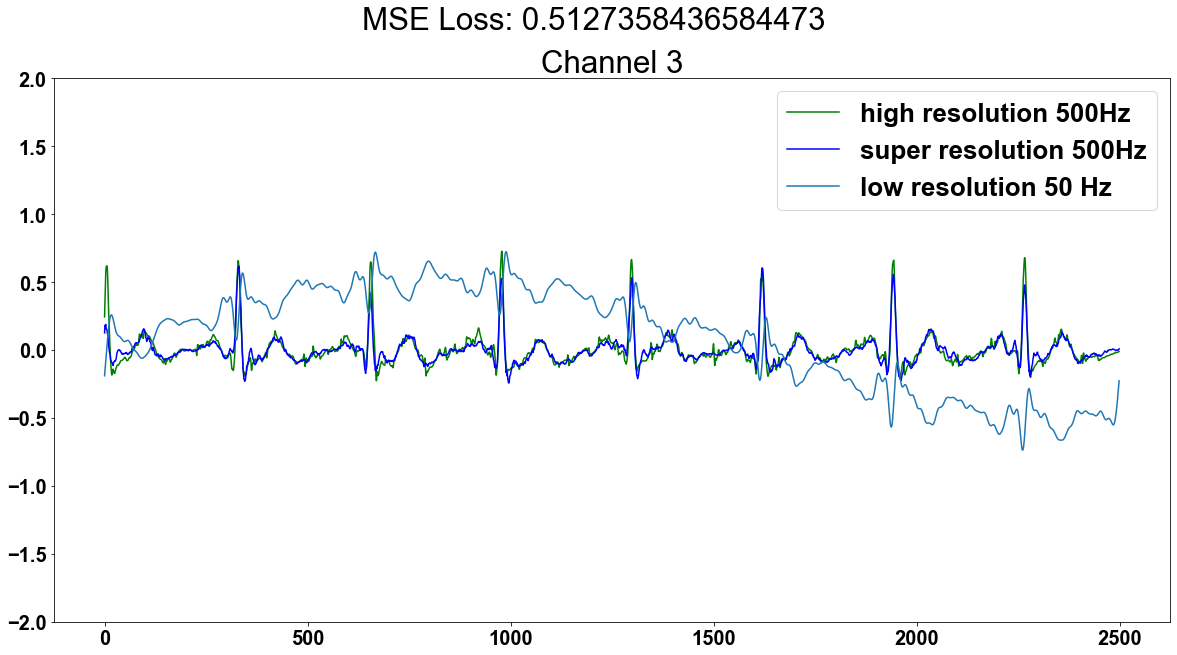

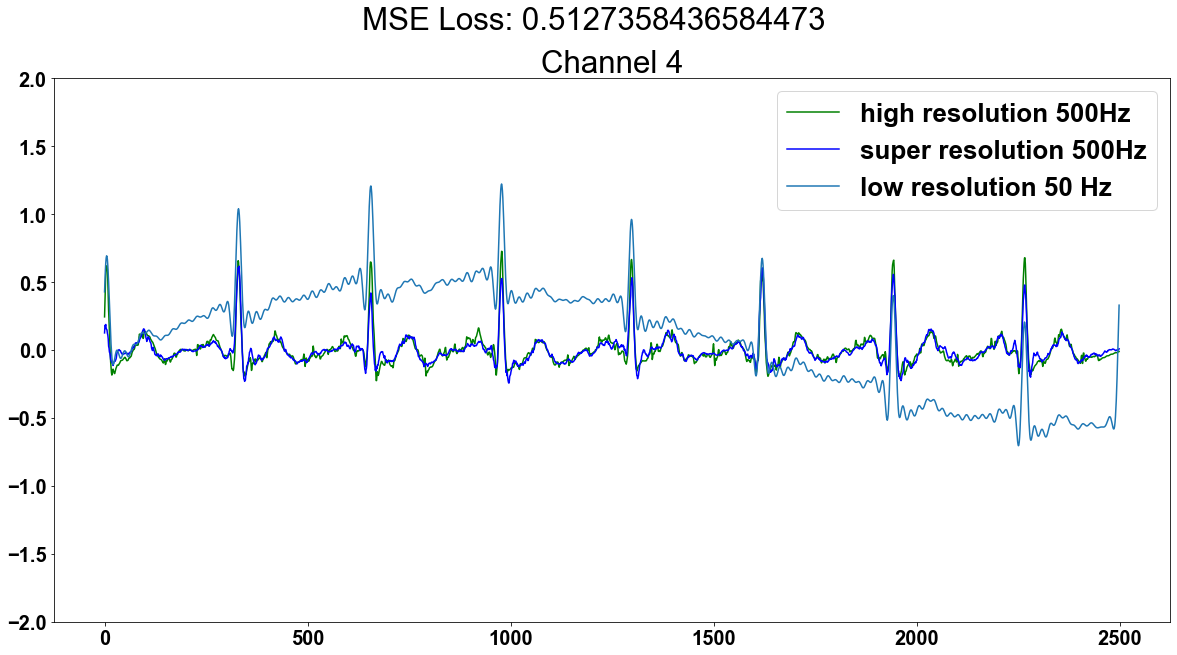

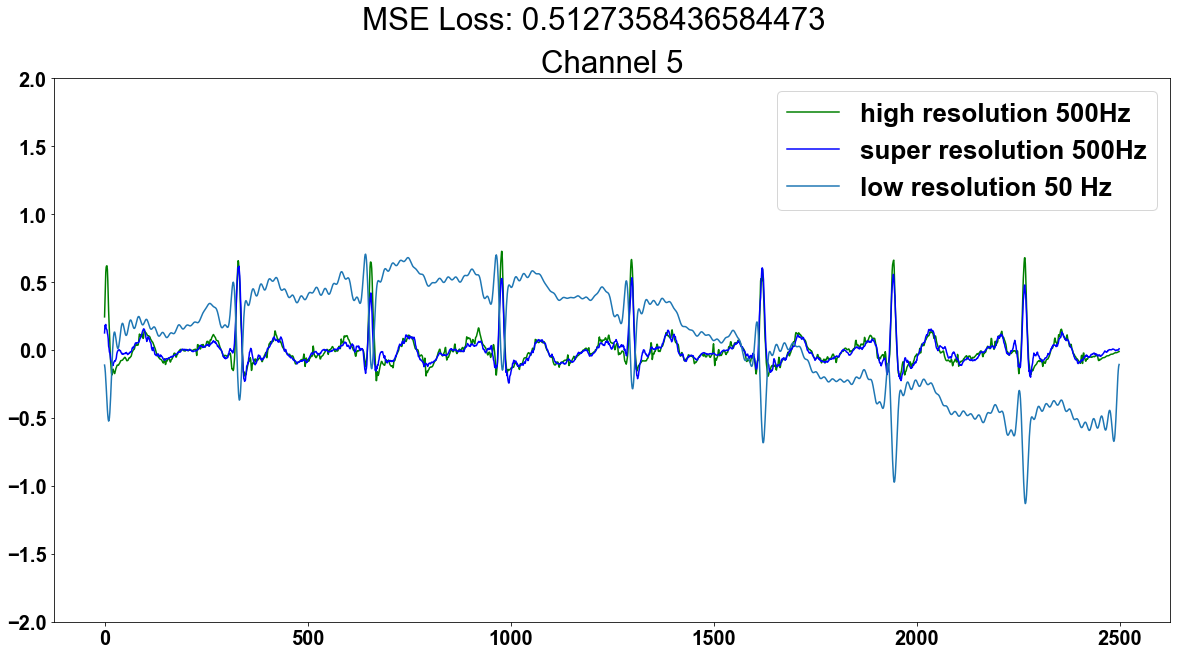

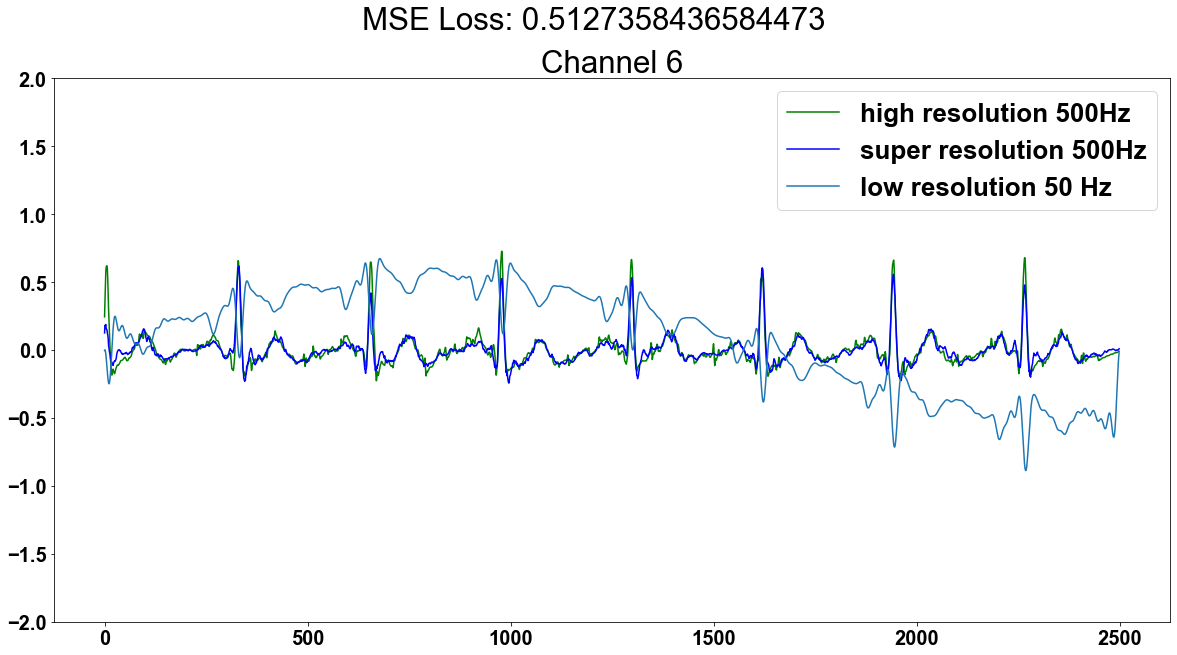

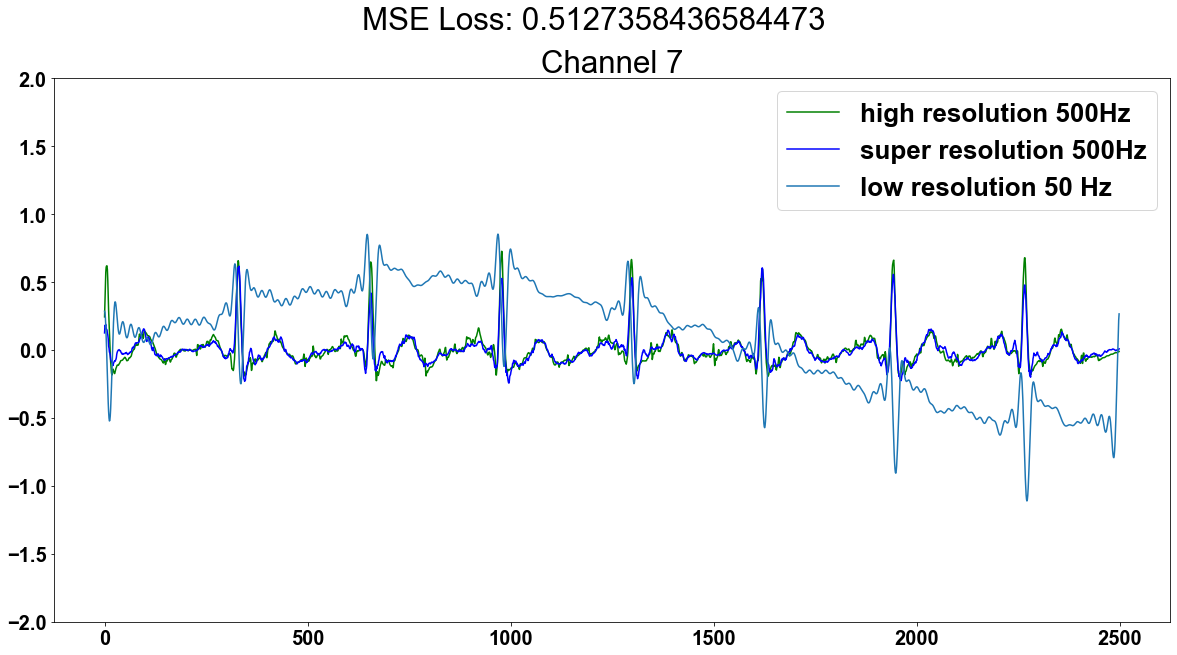

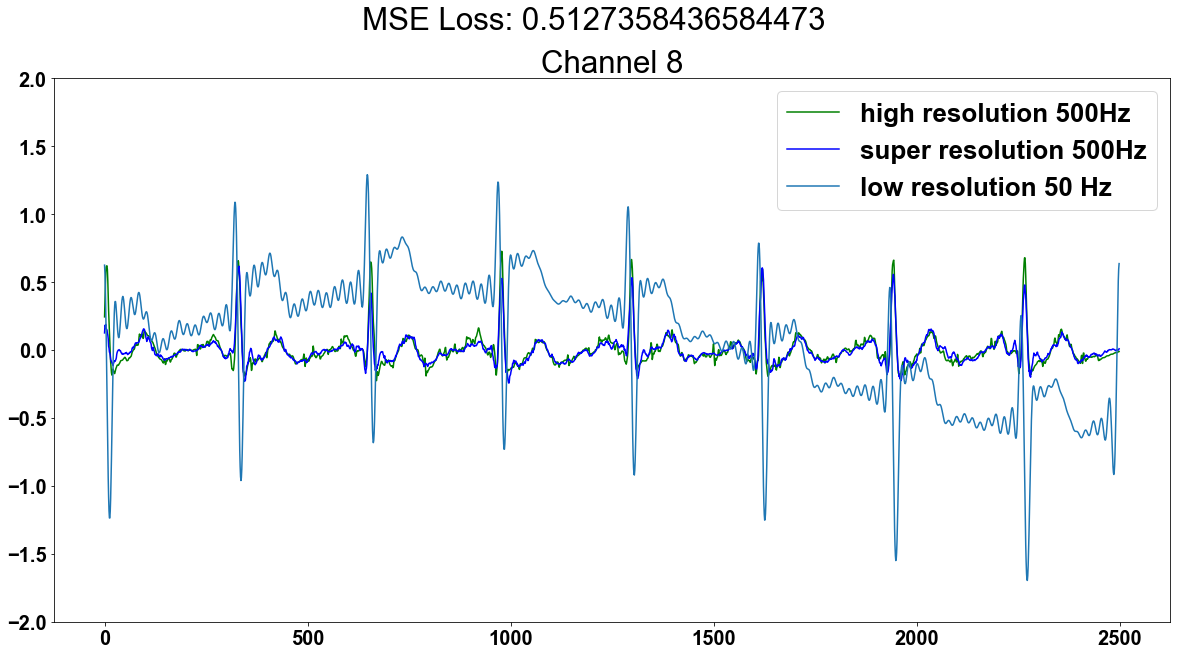

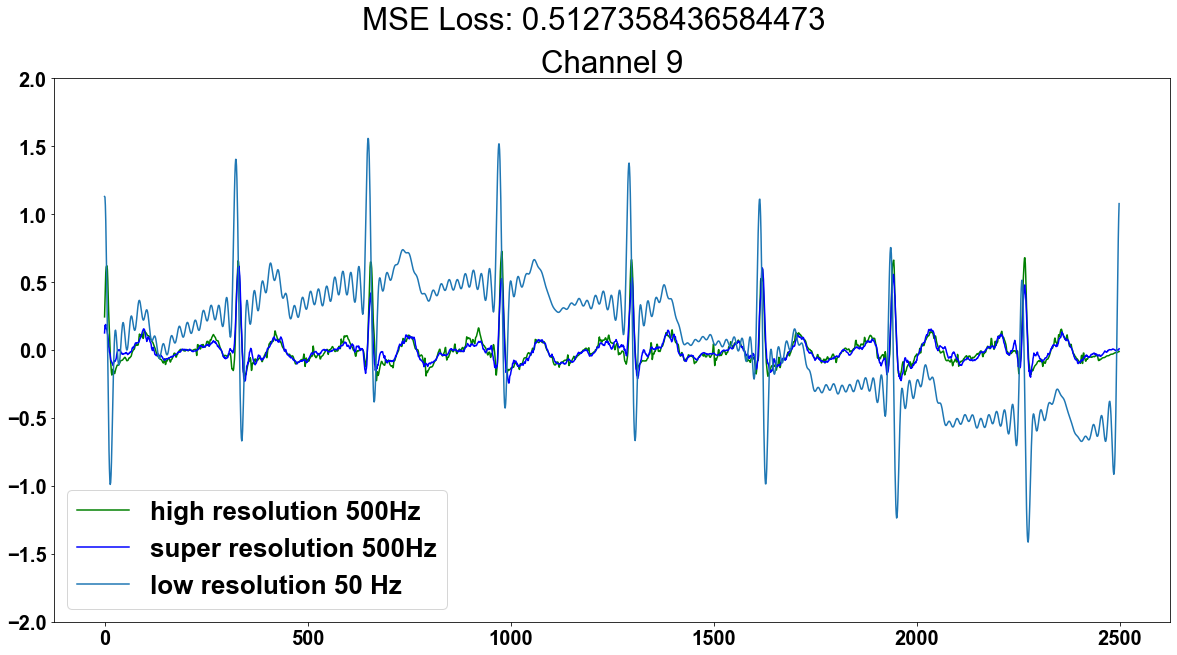

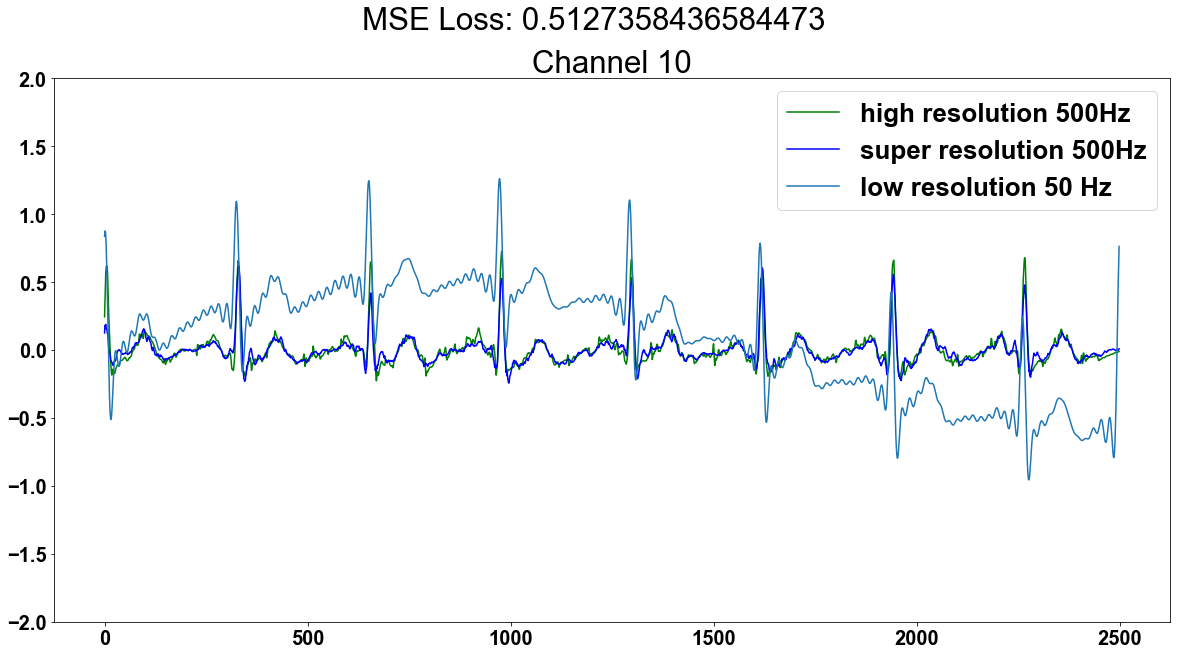

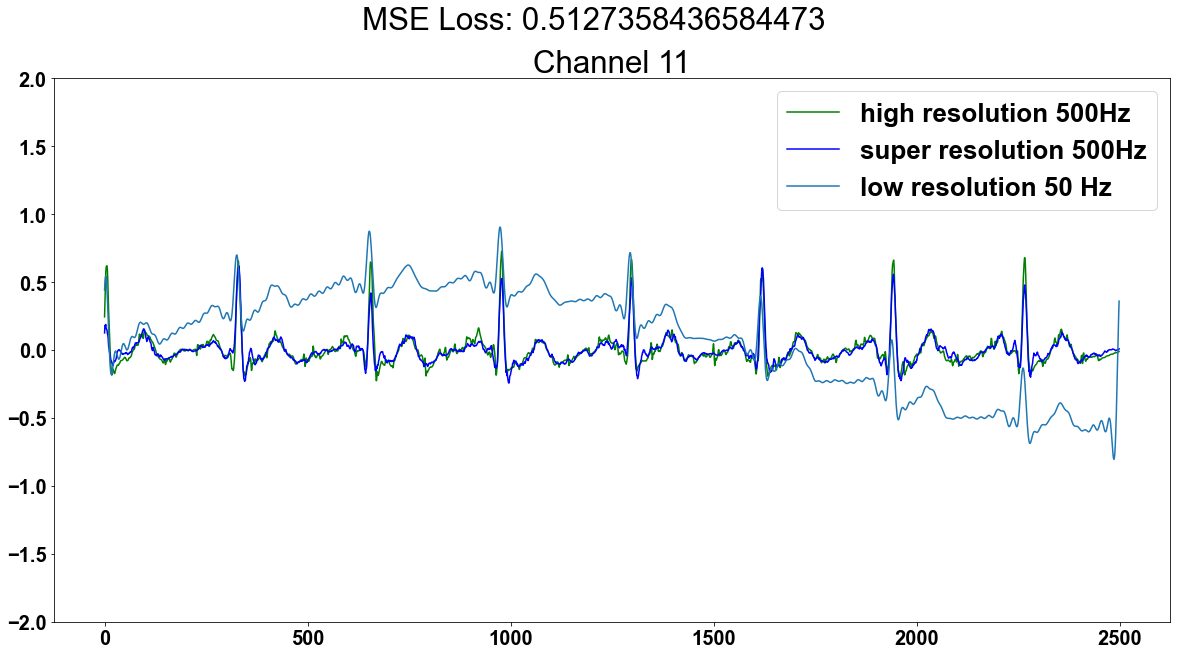

In [ ]:
n = len(testing_data_hr)
idx = idxs[0]#random.choice(np.arange(0, n, 1))
test_hr = testing_data_hr[idx].cpu()
test_noise = testing_data_noise[idx]
sr_window = model.predict([test_noise, None, None, None])[1].cpu()
test_noise = test_noise.cpu()

for ch in range(nchs):


    if sr_window.ndim == 2:
        sr_window = torch.unsqueeze(sr_window, dim = 0)
    fig = plot_super_resolution_final(test_hr, sr_window, channel = ch)

    up_lr = resample_signal(test_noise[0, :, :], fs = 500, fin = 50)
    plt.plot(up_lr[ch, :], label = "low resolution 50 Hz", alpha = 1)
    plt.legend()
    plt.ylim([-2, 2])

In [ ]:
fig.savefig("hr_vs_sr_bad.jpg", dpi=600)

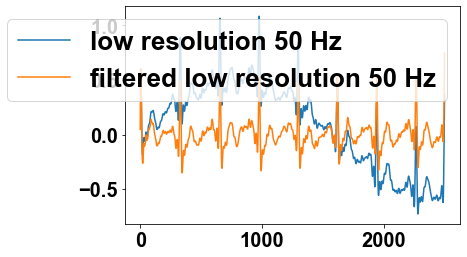

In [ ]:
filtered_lr = myfilter_hr(0.5, 150, up_lr, powerline = 50, fs = 500)
plt.plot(up_lr[0, :], label = "low resolution 50 Hz", alpha = 1)
plt.plot(filtered_lr[0, :], label = "filtered low resolution 50 Hz", alpha = 1)
plt.legend()

0


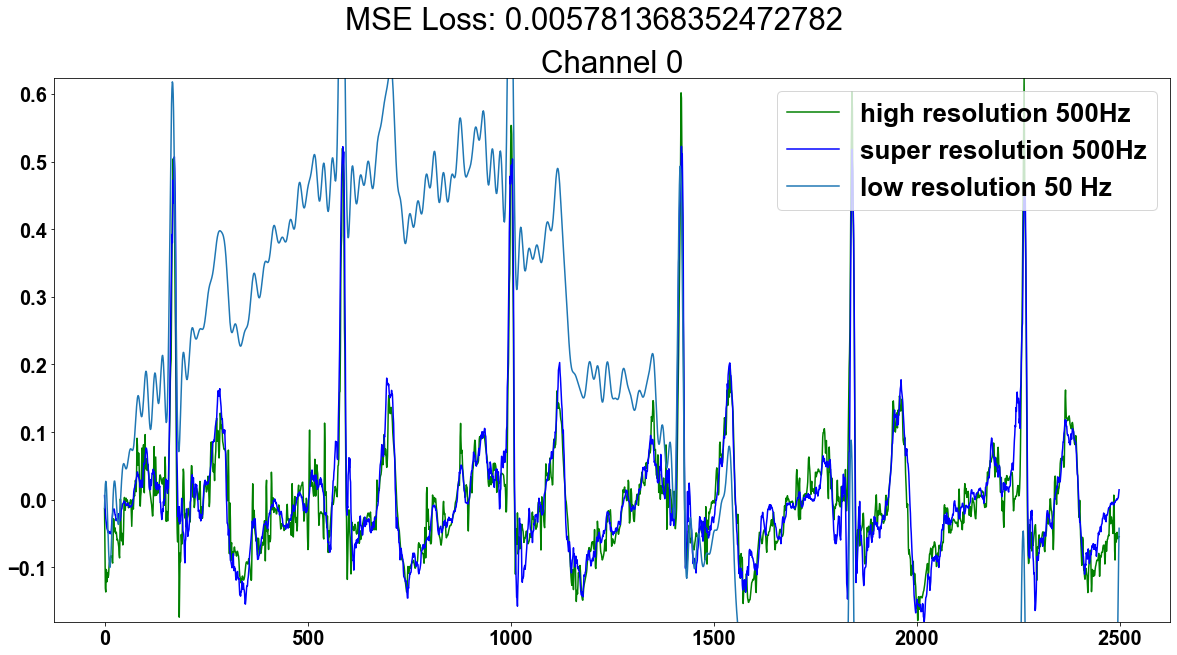

In [ ]:
idx = 0
print(idx)
test_hr = testing_data_hr[idx].cpu()
test_noise = testing_data_noise[idx]
sr_window = model.predict([test_noise, None, None, None])[1].cpu()
test_noise = test_noise.cpu()

if sr_window.ndim == 2:
    sr_window = torch.unsqueeze(sr_window, dim = 0)
fig = plot_super_resolution_final(test_hr, sr_window, channel = 0)

up_lr = resample_signal(test_noise[0, :, :], fs = 500, fin = 50)
plt.plot(up_lr[0, :], label = "low resolution 50 Hz", alpha = 1)
plt.legend()

In [ ]:
fig.savefig("hr_vs_sr_good.jpg", dpi=600)

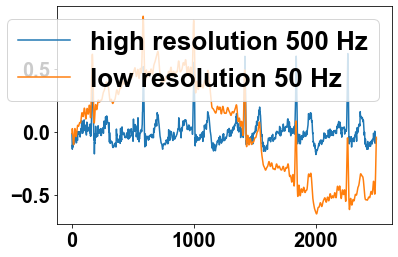

In [ ]:
plt.plot(test_hr[0, 0, :], label = "high resolution 500 Hz", alpha = 1)
plt.plot(up_lr[0, :], label = "low resolution 50 Hz", alpha = 1)
plt.legend()